In [1]:
from comparison_utils import *
from mpl_toolkits.mplot3d import Axes3D
import stream2 as st2
import markers_utils
%load_ext rpy2.ipython

def load_slingshot(res_path,slingshot_ncenters):
    %R -i res_path -i slingshot_ncenters
    %R path <- slingshot_ncenters
    curves_gmm = %R readRDS(paste(res_path,'slingshot_curves_gmm.rds',sep='_'))
    curves_kmeans = %R readRDS(paste(res_path,'slingshot_curves_kmeans',path,'.rds',sep='_'))
    cl1 = %R readRDS(paste(res_path,'slingshot_gmm.rds',sep='_'))
    cl2 = %R readRDS(paste(res_path,'slingshot_kmeans',path,'.rds',sep='_'))
    
    all_lineages = {}
    for n,curve in zip(['kmeans','GMM'],[curves_kmeans,curves_gmm]):
        lineages = dict(curve.items())
        for k,v in lineages.items():
            lineages[k] = dict(v.items())
            for k2,v2 in lineages[k].items():
                lineages[k][k2]=np.array(lineages[k][k2])
            lineages[k]['s']=lineages[k]['s'][lineages[k]['ord']-1]
        all_lineages[n]=lineages

    all_lineages['kmeans'] = [v['s'] for k,v in all_lineages['kmeans'].items()]
    all_lineages['GMM'] = [v['s'] for k,v in all_lineages['GMM'].items()]
    return all_lineages

def load_monocle(res_path,mcle_ncenters ,mcle_sigma,mcle_gamma):
    %R -i res_path -i mcle_ncenters -i mcle_sigma -i mcle_gamma
    path = %R path <- paste(mcle_ncenters,mcle_sigma,mcle_gamma,sep='_')
    path=path[0]
    nodep = %R readRDS(paste(res_path,'monocle_dp_mst',path,'.rds',sep='_'))
    nodep = np.array(nodep.T)
    stree = scipy.io.mmread(res_path+f'_monocle_stree_{path}_.mm')
    edges = np.argwhere(np.triu(stree.todense()))
    clus = %R readRDS(paste(res_path,'monocle_clus',path,'.rds',sep='_'))
    partitions = np.array(np.array(clus)[1])
    clusters = np.array(np.array(clus)[2])
    return nodep, stree, edges, partitions, clusters

def run_monocle_slingshot_tuned(data_path, res_path, slingshot_ncenters = 50,mcle_ncenters = 50,mcle_sigma = 0.01,mcle_gamma = 0.5,mcle_eps = 1e-05):
    ! /home/jo/anaconda3/envs/qz_monocle3/bin/Rscript run_monocle_slingshot_tuned.R $data_path $slingshot_ncenters $mcle_ncenters $mcle_sigma $mcle_gamma $mcle_eps $res_path
    
    lineages = load_slingshot(res_path,slingshot_ncenters)
    nodep, stree, edges, partitions, clusters = load_monocle(res_path,mcle_ncenters ,mcle_sigma ,mcle_gamma)
    return lineages, nodep, stree, edges, partitions, clusters

def run_epg(_anndata,n_nodes, n_clusters=20,epg_lambda=0.02,epg_mu=0.1,epg_alpha=0.02):
    X=_anndata.obsm['X_dr']

    kde = KernelDensity(kernel='gaussian',bandwidth=.5).fit(X)
    scores = kde.score_samples(X)
    scores = np.exp(scores)[:,None]
    pointweights = 1/scores
    pointweights /= np.sum(pointweights)  
    
    st2.tl.seed_graph(_anndata,obsm='X_dr',n_clusters=n_clusters)#,paths = [['mL2/3', 'mL4', 'mL5-1', 'mL5-2', 'mL6-1','mL6-2']],labels='Neuron type')
    st2.tl.learn_graph(_anndata,obsm='X_dr',n_nodes=n_nodes,epg_alpha=epg_alpha,epg_mu=epg_mu,epg_lambda=epg_lambda,#GPU=True,
                                                StoreGraphEvolution=True,#PointWeights=pointweights,
                                                MaxNumberOfGraphCandidatesDict={'AddNode2Node': 20, 'BisectEdge': 10, 'ShrinkEdge':np.inf},
                                                #new kwargs
                                                #epg_pseudotime=np.array(_anndata.X[:,0]+_anndata.X[:,1]),
                                                #epg_pseudotimeLambda=0.005,
                                                #epg_FixNodesAtPoints=[[1681]],#[[110]],#[[2445]],
                                                verbose=1,
                                                use_seed=True
                                               )
    st2.tl.infer_pseudotime(_anndata,source=0)
    epg_nodep=_anndata.uns['epg']['node_pos']
    epg_edges=_anndata.uns['epg']['edge']

    return epg_nodep, epg_edges, pointweights


def get_cycle_pseudotime(adata,merged_nodep,merged_edges,key='epg',cycle_idx=0):
    
    if adata.uns[key]["params"]["obsm"] is not None:
        mat = adata.obsm[adata.uns[key]["params"]["obsm"]]
    elif adata.uns[key]["params"]["layer"] is not None:
        mat = adata.obsm[adata.uns[key]["params"]["layer"]]
    else:
        mat = adata.X

    adata.uns[key]['node_pos'] = merged_nodep
    adata.uns[key]['edge'] = merged_edges
    st2.tl._elpigraph._store_graph_attributes(_anndata,mat,key)

    G = nx.Graph(merged_edges.tolist())
    cycle_nodes = graph_loops.find_all_cycles(G)[cycle_idx]
    
    d=np.array([G.degree[e] for e in cycle_nodes])
    branching_node = np.array(cycle_nodes)[d>2][0]
    branching_node_idx = cycle_nodes.index(branching_node)
    branching_node_cycle_nn = np.array(cycle_nodes)[[branching_node_idx-1,branching_node_idx+1]]

    st2.tl.infer_pseudotime(adata,source=branching_node,target=branching_node_cycle_nn[1],
                            nodes_to_include=[branching_node_cycle_nn[0]])
    st2.pl.graph(adata,color=['epg_pseudotime'],show_text=True,fig_size=(6,6),fontsize=20,alpha=0.4,size=5)
    
def get_tp(gene_list,vars_bool):
    tp_score = []
    perc_detected = []
    print(vars_bool.shape)
    for i,n in enumerate(vars_bool.index):
        print(i,end='\r')
        if n in gene_list:
            vars_bool[n] = True
        perc_detected.append(sum(vars_bool[:n])/len(gene_list))
        tp_score.append(sum(vars_bool[:n])/(i+1))
    return perc_detected, tp_score

In [2]:
adata=sc.read('../notebooks/erisone/stream_layers_jon_promoter.h5ad')
#sc.pp.pca(adata)
adata.obsm['X_umap']=adata.obsm['X_dr']
data_path = "../data/DNA.txt"
np.savetxt(data_path,adata.obsm['X_umap'])

In [3]:
epg_nodep, epg_edges, epg_pointweights = run_epg(adata,n_nodes=30,epg_alpha=0.02)

Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...
Constructing tree 1 of 1 / Subset 1 of 1
Computing EPG with  30  nodes on  2278  points and  2  dimensions

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

4||21	1.0653	21	20	11	4	0	0	0.6035	0.5379	0.9505	0.9558	0.4202	0.0416	0.8737	18.3483	0
3||22	0.9947	22	21	14	3	0	0	0.5779	0.521	0.9526	0.9572	0.3849	0.0319	0.7024	15.4536	0
3||23	0.9801	23	22	15	3	0	0	0.5803	0.5277	0.9524	0.9567	0.3651	0.0347	0.7977	18.3465	0
3||24	0.9639	24	23	16	3	0	0	0.5695	0.5188	0.9533	0.9574	0.3594	0.0351	0.8423	20.2159	0
3||25	0.9315	25	24	17	3	0	0	0.5483	0.5016	0.955	0.9588	0.3521	0.031	0.7755	19.3869	0
3||26	0.9026	26	25	18	3	0	0	0.5276	0.4848	0.9567	0.9602	0.3458	0.0292	0.7603	19.7686	0
3||27	0.8801	27	26	19	3	0	0	0.5114	0.4703	0.958	0.9614	0.341	0.0276	0.7452	20.1196	0
3||28	0.8633	28	27	20	3	0	0	0.5068	0.4676	0.9584	0.9616	0.3306	0.0258	0.7233	20.2516	0
3||29	0.

In [4]:
sc.pp.highly_variable_genes(adata,subset=True)

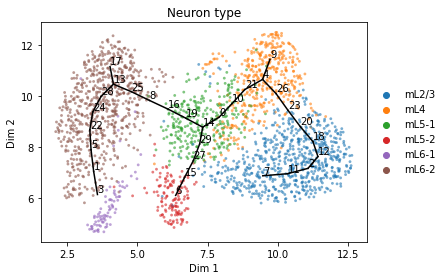

In [5]:
st2.pl.graph(adata,show_text=True,alpha=0.6,color=['Neuron type'])

In [18]:
import scipy.spatial.qhull

In [28]:
scipy.spatial.qhull.

<module 'scipy.spatial._qhull' from '/home/jo/anaconda3/envs/c4/lib/python3.8/site-packages/scipy/spatial/_qhull.cpython-38-x86_64-linux-gnu.so'>

In [9]:
try:
    del adata.uns['transition_markers']
    del adata.uns['scaled_marker_expr']
except:
    pass
adata.uns['workdir']=''
st2.tl.detect_transition_markers(adata,source=3,target=13,fc_cutoff=0.1,method='xi')
adata.uns['transition_markers']['Path_3-None-13']

Filtering out markers that are expressed in less than 5 cells ...
10944 markers are being scanned ...


,stat,logfc,pval,qval,initial_mean,final_mean,initial_mean_ori,final_mean_ori
Rorc_1_12392_prCpG,0.149523,1.023954,2.423716e-08,0.000068,0.759875,0.368599,0.759875,0.368599
Cct6a_1_15232_prCpG,0.135168,0.528855,4.050722e-07,0.000540,0.790895,0.545104,0.790895,0.545104
Cct6b_1_3076_prCpG,0.133290,0.432665,5.740709e-07,0.000540,0.800525,0.590511,0.800525,0.590512
Fbxo5_1_562_prCG,0.128235,0.232606,1.435111e-06,0.000675,0.857042,0.727936,0.857042,0.727936
G6pc_1_474_prTATA,0.128235,0.232606,1.435111e-06,0.000675,0.857042,0.727936,0.857042,0.727936
...,...,...,...,...,...,...,...,...
Vsig8_1_491_prCG,-0.042900,0.167076,9.412801e-01,0.942615,0.495747,0.440442,0.495747,0.440442
Mrpl10_1_3300_prCpG,-0.044922,0.249405,9.494357e-01,0.950445,0.288981,0.241516,0.288982,0.241516
Fyco1_1_20609_prCpG,-0.055857,0.152562,9.792502e-01,0.979944,0.294785,0.264201,0.294785,0.264201
Galnt2_1_9051_prCG,-0.068227,0.144287,9.936117e-01,0.993612,0.319029,0.353637,0.319029,0.353637


In [157]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [216]:
x=np.array(adata[:,'2410004A20Rik_1_3762_prCCAAT'].X)[~np.isnan(adata.obs['epg_pseudotime'])].flatten()
y=np.array(adata.obs['epg_pseudotime'])[~np.isnan(adata.obs['epg_pseudotime'])]

In [214]:
x=np.array(df_cells.iloc[:, ix_cutoff].loc[:,'2410004A20Rik_1_3762_prCCAAT']).flatten()
y=np.array(pseudotime_cells)

In [212]:
shuf=np.arange(len(x))
np.random.shuffle(shuf)
x=x[shuf]
y=y[shuf]

In [217]:
import math

_xicorr_inner(x,y,len(x))

(-0.033302724172282305, 0.9006475018934927)

In [201]:
import math

xicorr_orig(y,x)

0.4122884037660467

In [182]:
%%R -i x -i y
calculateXI <- function(xvec, yvec, simple=TRUE, seed=12133331) {
## The following function computes the new correlation coefficient.
## Main simple correlation calculation in the case of two vectors xvec and yvec, no missing.
## This will eventually benefit from being written in C for speed.
## Because of the randomness in breaking up ties, we fix a seed.
  set.seed(seed)
# n is the sample size.
  n <- length(xvec)							
# PI is the rank vector for x, with ties broken at random
  PI <- rank(xvec, ties.method = "average")	
# fr[i] is number of j s.t. y[j] <= y[i], divided by n.  
  fr <- rank(yvec, ties.method = "average")/n		
# gr[i] is number of j s.t. y[j] >= y[i], divided by n.  
  gr <- rank((- yvec), ties.method = "average")/n	
# order of the x's, ties broken at random.
  ord <- order(PI)					
# Rearrange fr according to ord.  
  fr <- fr[ord]								
# xi is calculated in the next three lines:
  A1 <- sum(abs(fr [1:(n - 1)] - fr [2:n]))/ (2*n)
  CU <- mean(gr* (1 - gr))
  xi <- 1 - A1/CU
  if (simple == TRUE)
    return(xi)
  else
    return(list(xi = xi,fr = fr,CU = CU))
}

calculateXI(x,y)

[1] 0.9591228


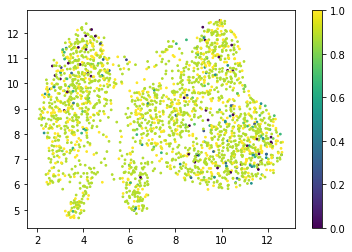

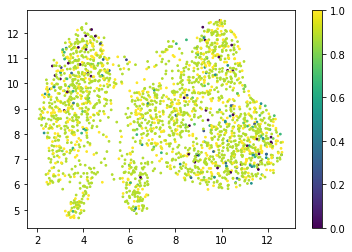

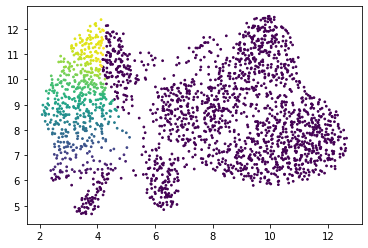

In [35]:
c=adata.obs['epg_pseudotime'].copy()
c[np.isnan(c)]=0
plt.scatter(*adata.obsm['X_umap'].T,c=np.array(adata[:,'2410004A20Rik_1_3762_prCCAAT'].X),s=3);plt.colorbar();plt.show()
plt.scatter(*adata.obsm['X_umap'].T,c=adata.uns['scaled_marker_expr']['2410004A20Rik_1_3762_prCCAAT'],s=3);plt.colorbar();plt.show()
plt.scatter(*adata.obsm['X_umap'].T,c=c,s=3);plt.show()

In [116]:
key='epg'
percentile_expr=95
min_num_cells=5
fc_cutoff=0
method="xi"
key="epg"

In [118]:
import numpy as np
import numba as nb
import pandas as pd
import scipy
import os
import math
from copy import deepcopy
from statsmodels.sandbox.stats.multicomp import multipletests


@nb.njit
def nb_unique1d(ar):
    """
    Numba speedup
    """
    ar = ar.flatten()
    perm = ar.argsort(kind="mergesort")
    aux = ar[perm]

    mask = np.empty(aux.shape, dtype=np.bool_)
    mask[:1] = True
    if aux.shape[0] > 0 and aux.dtype.kind in "cfmM" and np.isnan(aux[-1]):
        if aux.dtype.kind == "c":  # for complex all NaNs are considered equivalent
            aux_firstnan = np.searchsorted(np.isnan(aux), True, side="left")
        else:
            aux_firstnan = np.searchsorted(aux, aux[-1], side="left")
        mask[1:aux_firstnan] = aux[1:aux_firstnan] != aux[: aux_firstnan - 1]
        mask[aux_firstnan] = True
        mask[aux_firstnan + 1 :] = False
    else:
        mask[1:] = aux[1:] != aux[:-1]

    imask = np.cumsum(mask) - 1
    inv_idx = np.empty(mask.shape, dtype=np.intp)
    inv_idx[perm] = imask
    idx = np.append(np.nonzero(mask)[0], mask.size)

    # idx      #inverse   #counts
    return aux[mask], perm[mask], inv_idx, np.diff(idx)


@nb.njit
def normal_cdf(x):
    #'Cumulative distribution function for the standard normal distribution'
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0


@nb.njit
def avg_ties(X):
    """ Same as scipy.stats.rankdata method="average" """
    xi = np.argsort(X)
    xi_rank = np.argsort(xi)
    unique, _, inverse, c_ = nb_unique1d(X)
    unique_rank_sum = np.zeros_like(unique)
    for i0, inv in enumerate(inverse):
        unique_rank_sum[inv] += xi_rank[i0]
    unique_count = np.zeros_like(unique)
    for i0, inv in enumerate(inverse):
        unique_count[inv] += 1
    unique_rank_mean = unique_rank_sum / unique_count
    rank_mean = unique_rank_mean[inverse]
    return rank_mean + 1


@nb.njit
def _xicorr_inner(x, y, n):
    """ Translated from R https://github.com/cran/XICOR/ """
    # ---corr
    PI = avg_ties(x)
    fr = avg_ties(y) / n
    gr = avg_ties(-y) / n
    fr = fr[np.argsort(PI, kind="mergesort")]

    CU = np.mean(gr * (1 - gr))
    A1 = np.abs(np.diff(fr)).sum() / (2 * n)
    xi = 1 - A1 / CU

    # ---pval
    qfr = np.sort(fr)
    ind = np.arange(n) + 1
    ind2 = np.array([2 * n - 2 * ind[i - 1] + 1 for i in ind])

    ai = np.mean(ind2 * qfr * qfr) / n
    ci = np.mean(ind2 * qfr) / n
    cq = np.cumsum(qfr)

    m = (cq + (n - ind) * qfr) / n
    b = np.mean(m ** 2)
    v = (ai - 2 * b + np.square(ci)) / np.square(CU)

    # sd = np.sqrt(v/n)
    pval = 1 - normal_cdf(np.sqrt(n) * xi / np.sqrt(v))
    return xi, pval


@nb.njit
def _xicorr_v2(X, Y, n):
    """xi correlation coefficient"""
    xi = np.argsort(X, kind="quicksort")
    Y = Y[xi]
    _, _, b, c = nb_unique1d(Y)
    r = np.cumsum(c)[b]
    _, _, b, c = nb_unique1d(-Y)
    l = np.cumsum(c)[b]
    return 1 - n * np.abs(np.diff(r)).sum() / (2 * (l * (n - l)).sum()), np.nan


@nb.njit(parallel=True)
def _xicorr_loop_parallel(X, y):
    """Numba fast parallel xi correlation coefficient
    X,Y 0 dimensional np.arrays"""
    n = len(X)
    corrs = np.zeros(X.shape[1])
    pvals = np.zeros(X.shape[1])
    for i in nb.prange(X.shape[1]):
        corrs[i], pvals[i] = _xicorr_v2(X[:, i], y, n)
    return corrs, pvals


def nb_spearman(x, Y):
    """
    Fast equivalent to
    for i in range(y.shape[1]): spearmanr(x,y[:,i]).correlation
    """
    return pearson_corr(_rankdata(x[None]), _rankdata(Y.T))


def pearson_corr(arr1, arr2):
    """
    Pearson correlation along the last dimension of two multidimensional arrays.
    """
    mean1 = np.mean(arr1, axis=-1, keepdims=1)
    mean2 = np.mean(arr2, axis=-1, keepdims=1)
    dev1, dev2 = arr1 - mean1, arr2 - mean2
    sqdev1, sqdev2 = np.square(dev1), np.square(dev2)
    numer = np.sum(dev1 * dev2, axis=-1)  # Covariance
    var1, var2 = np.sum(sqdev1, axis=-1), np.sum(sqdev2, axis=-1)  # Variances
    denom = np.sqrt(var1 * var2)

    # Divide numerator by denominator, but use NaN where the denominator is 0
    return np.divide(numer, denom, out=np.full_like(numer, np.nan), where=(denom != 0))


@nb.njit(parallel=True, fastmath=True)
def _rankdata(X):
    """reimplementing scipy.stats.rankdata faster """
    tmp = np.zeros_like(X)
    for i in nb.prange(X.shape[0]):
        tmp[i] = _rankdata_inner(X[i])
    return tmp


@nb.njit
def _rankdata_inner(x):
    """inner loop for _rankdata"""
    sorter = np.argsort(x)

    inv = np.empty(sorter.size, dtype=np.intp)
    inv[sorter] = np.arange(sorter.size, dtype=np.intp)

    x = x[sorter]
    obs = np.concatenate((np.array([True]), x[1:] != x[:-1]))
    dense = obs.cumsum()[inv]

    # cumulative counts of each unique value
    count = np.append(np.nonzero(obs)[0], len(obs))
    # average method
    return 0.5 * (count[dense] + count[dense - 1] + 1)


def p_val(r, n):
    t = r * np.sqrt((n - 2) / (1 - r ** 2))
    return scipy.stats.t.sf(np.abs(t), n - 1) * 2


def scale_marker_expr(df_marker_detection, percentile_expr):
    ### optimal version for STREAM1
    ind_neg = df_marker_detection.min() < 0
    ind_pos = df_marker_detection.min() >= 0
    df_neg = df_marker_detection.loc[:, ind_neg]
    df_pos = df_marker_detection.loc[:, ind_pos]

    if ind_neg.sum() > 0:
        print("Matrix contains negative values...")
        ### genes with negative values
        minValues = df_neg.apply(
            lambda x: np.percentile(x[x < 0], 100 - percentile_expr), axis=0
        )
        maxValues = df_neg.apply(
            lambda x: np.percentile(x[x > 0], percentile_expr), axis=0
        )
        for i in range(df_neg.shape[1]):
            df_gene = df_neg.iloc[:, i].copy(deep=True)
            df_gene[df_gene < minValues[i]] = minValues[i]
            df_gene[df_gene > maxValues[i]] = maxValues[i]
            df_neg.iloc[:, i] = df_gene - minValues[i]
        df_neg = df_neg.copy(deep=True)
        maxValues = df_neg.max(axis=0)
        df_neg_scaled = df_neg / maxValues[:, None].T
    else:
        df_neg_scaled = pd.DataFrame(index=df_neg.index)

    if ind_pos.sum() > 0:
        maxValues = df_pos.apply(
            lambda x: np.percentile(x[x > 0], percentile_expr), axis=0
        )
        df_pos_scaled = df_pos / maxValues[:, None].T
        df_pos_scaled[df_pos_scaled > 1] = 1
    else:
        df_pos_scaled = pd.DataFrame(index=df_pos.index)

    df_marker_detection_scaled = pd.concat([df_neg_scaled, df_pos_scaled], axis=1)

    return df_marker_detection_scaled


def detect_transition_markers(
    adata,
    percentile_expr=95,
    min_num_cells=5,
    fc_cutoff=0,
    method="spearman",
    key="epg",
):

    file_path = os.path.join(adata.uns["workdir"], "transition_markers")
    if not os.path.exists(file_path):
        os.makedirs(file_path)

    source = adata.uns[f"{key}_pseudotime_params"]["source"]
    target = adata.uns[f"{key}_pseudotime_params"]["target"]
    nodes_to_include = adata.uns[f"{key}_pseudotime_params"]["nodes_to_include"]
    cells = adata.obs_names[~np.isnan(adata.obs[f"{key}_pseudotime"])]
    path_alias = "Path_%s-%s-%s" % (source, nodes_to_include, target)

    #### Scale matrix with expressed markers
    input_markers = adata.var_names.tolist()
    df_sc = pd.DataFrame(
        index=adata.obs_names.tolist(),
        data=adata[:, input_markers].X,
        columns=input_markers,
    )

    print(
        "Filtering out markers that are expressed in less than "
        + str(min_num_cells)
        + " cells ..."
    )
    input_markers_expressed = np.array(input_markers)[
        np.where((df_sc[input_markers] > 0).sum(axis=0) > min_num_cells)[0]
    ].tolist()
    df_marker_detection = df_sc[input_markers_expressed].copy()

    df_scaled_marker_expr = scale_marker_expr(df_marker_detection, percentile_expr)
    adata.uns["scaled_marker_expr"] = df_scaled_marker_expr

    print(str(len(input_markers_expressed)) + " markers are being scanned ...")

    df_cells = deepcopy(df_scaled_marker_expr.loc[cells])
    pseudotime_cells = adata.obs[f"{key}_pseudotime"][cells]
    df_cells_sort = df_cells.iloc[np.argsort(pseudotime_cells)]
    pseudotime_cells_sort = pseudotime_cells[np.argsort(pseudotime_cells)]

    dict_tg_edges = dict()

    id_initial = range(0, int(df_cells_sort.shape[0] * 0.2))
    id_final = range(int(df_cells_sort.shape[0] * 0.8), int(df_cells_sort.shape[0] * 1))
    values_initial, values_final = (
        df_cells_sort.iloc[id_initial, :],
        df_cells_sort.iloc[id_final, :],
    )
    diff_initial_final = np.abs(values_final.mean(axis=0) - values_initial.mean(axis=0))

    ### original expression
    df_cells_ori = deepcopy(df_marker_detection.loc[cells])
    df_cells_sort_ori = df_cells_ori.iloc[np.argsort(pseudotime_cells)]
    values_initial_ori, values_final_ori = (
        df_cells_sort_ori.iloc[id_initial, :],
        df_cells_sort_ori.iloc[id_final, :],
    )

    ix_pos = diff_initial_final > 0
    logfc = pd.Series(np.zeros(len(diff_initial_final)), index=diff_initial_final.index)
    logfc[ix_pos] = np.log2(
        (np.maximum(values_final.mean(axis=0), values_initial.mean(axis=0)) + 0.01)
        / (np.minimum(values_final.mean(axis=0), values_initial.mean(axis=0)) + 0.01)
    )

    ix_cutoff = np.array(logfc > fc_cutoff)

    if sum(ix_cutoff) == 0:
        print(
            "No Transition markers are detected in branch with nodes "
            + str(source)
            + " to "
            + str(target)
        )

    else:
        df_stat_pval_qval = pd.DataFrame(
            np.full((sum(ix_cutoff), 8), np.nan),
            columns=[
                "stat",
                "logfc",
                "pval",
                "qval",
                "initial_mean",
                "final_mean",
                "initial_mean_ori",
                "final_mean_ori",
            ],
            index=df_cells_sort.columns[ix_cutoff],
        )

        if method == "spearman":
            df_stat_pval_qval["stat"] = nb_spearman(
                np.array(pseudotime_cells_sort),
                np.array(df_cells_sort.iloc[:, ix_cutoff]),
            )
            df_stat_pval_qval["pval"] = p_val(
                df_stat_pval_qval["stat"], len(pseudotime_cells_sort)
            )
        elif method == "xi":
            res = _xicorr_loop_parallel(
                np.array(df_cells_sort.iloc[:, ix_cutoff]),
                np.array(pseudotime_cells_sort),
            )
            df_stat_pval_qval["stat"] = res[0]
            df_stat_pval_qval["pval"] = res[1]
        else:
            raise ValueError("method must be one of 'spearman', 'xi'")

        df_stat_pval_qval["logfc"] = logfc

        p_values = df_stat_pval_qval["pval"]
        q_values = multipletests(p_values, method="fdr_bh")[1]
        df_stat_pval_qval["qval"] = q_values
        df_stat_pval_qval["initial_mean"] = values_initial.mean(axis=0)
        df_stat_pval_qval["final_mean"] = values_final.mean(axis=0)
        df_stat_pval_qval["initial_mean_ori"] = values_initial_ori.mean(axis=0)
        df_stat_pval_qval["final_mean_ori"] = values_final_ori.mean(axis=0)

        dict_tg_edges[path_alias] = df_stat_pval_qval.sort_values(["qval"])

        dict_tg_edges[path_alias].to_csv(
            os.path.join(
                file_path,
                "transition_markers_path_" + str(source) + "-" + str(target) + ".tsv",
            ),
            sep="\t",
            index=True,
        )

    if "transition_markers" in adata.uns.keys():
        adata.uns["transition_markers"].update(dict_tg_edges)
    else:
        adata.uns["transition_markers"] = dict_tg_edges


In [119]:
file_path = os.path.join(adata.uns["workdir"], "transition_markers")
if not os.path.exists(file_path):
    os.makedirs(file_path)

source = adata.uns[f"{key}_pseudotime_params"]["source"]
target = adata.uns[f"{key}_pseudotime_params"]["target"]
nodes_to_include = adata.uns[f"{key}_pseudotime_params"]["nodes_to_include"]
cells = adata.obs_names[~np.isnan(adata.obs[f"{key}_pseudotime"])]
path_alias = "Path_%s-%s-%s" % (source, nodes_to_include, target)

#### Scale matrix with expressed markers
input_markers = adata.var_names.tolist()
df_sc = pd.DataFrame(
    index=adata.obs_names.tolist(),
    data=adata[:, input_markers].X,
    columns=input_markers,
)

print(
    "Filtering out markers that are expressed in less than "
    + str(min_num_cells)
    + " cells ..."
)
input_markers_expressed = np.array(input_markers)[
    np.where((df_sc[input_markers] > 0).sum(axis=0) > min_num_cells)[0]
].tolist()
df_marker_detection = df_sc[input_markers_expressed].copy()

df_scaled_marker_expr = scale_marker_expr(df_marker_detection, percentile_expr)
adata.uns["scaled_marker_expr"] = df_scaled_marker_expr

print(str(len(input_markers_expressed)) + " markers are being scanned ...")

df_cells = deepcopy(df_scaled_marker_expr.loc[cells])
pseudotime_cells = adata.obs[f"{key}_pseudotime"][cells]
df_cells_sort = df_cells.iloc[np.argsort(pseudotime_cells)]
pseudotime_cells_sort = pseudotime_cells[np.argsort(pseudotime_cells)]

dict_tg_edges = dict()

id_initial = range(0, int(df_cells_sort.shape[0] * 0.2))
id_final = range(int(df_cells_sort.shape[0] * 0.8), int(df_cells_sort.shape[0] * 1))
values_initial, values_final = (
    df_cells_sort.iloc[id_initial, :],
    df_cells_sort.iloc[id_final, :],
)
diff_initial_final = np.abs(values_final.mean(axis=0) - values_initial.mean(axis=0))

### original expression
df_cells_ori = deepcopy(df_marker_detection.loc[cells])
df_cells_sort_ori = df_cells_ori.iloc[np.argsort(pseudotime_cells)]
values_initial_ori, values_final_ori = (
    df_cells_sort_ori.iloc[id_initial, :],
    df_cells_sort_ori.iloc[id_final, :],
)

ix_pos = diff_initial_final > 0
logfc = pd.Series(np.zeros(len(diff_initial_final)), index=diff_initial_final.index)
logfc[ix_pos] = np.log2(
    (np.maximum(values_final.mean(axis=0), values_initial.mean(axis=0)) + 0.01)
    / (np.minimum(values_final.mean(axis=0), values_initial.mean(axis=0)) + 0.01)
)

ix_cutoff = np.array(logfc > fc_cutoff)

if sum(ix_cutoff) == 0:
    print(
        "No Transition markers are detected in branch with nodes "
        + str(source)
        + " to "
        + str(target)
    )

else:
    df_stat_pval_qval = pd.DataFrame(
        np.full((sum(ix_cutoff), 8), np.nan),
        columns=[
            "stat",
            "logfc",
            "pval",
            "qval",
            "initial_mean",
            "final_mean",
            "initial_mean_ori",
            "final_mean_ori",
        ],
        index=df_cells_sort.columns[ix_cutoff],
    )

    if method == "spearman":
        df_stat_pval_qval["stat"] = nb_spearman(
            np.array(pseudotime_cells_sort),
            np.array(df_cells_sort.iloc[:, ix_cutoff]),
        )
        df_stat_pval_qval["pval"] = p_val(
            df_stat_pval_qval["stat"], len(pseudotime_cells_sort)
        )
    elif method == "xi":
        res = _xicorr_loop_parallel(
            np.array(df_cells_sort.iloc[:, ix_cutoff]),
            np.array(pseudotime_cells_sort),
        )
        df_stat_pval_qval["stat"] = res[0]
        df_stat_pval_qval["pval"] = res[1]
    else:
        raise ValueError("method must be one of 'spearman', 'xi'")

    df_stat_pval_qval["logfc"] = logfc

    p_values = df_stat_pval_qval["pval"]
    q_values = multipletests(p_values, method="fdr_bh")[1]
    df_stat_pval_qval["qval"] = q_values
    df_stat_pval_qval["initial_mean"] = values_initial.mean(axis=0)
    df_stat_pval_qval["final_mean"] = values_final.mean(axis=0)
    df_stat_pval_qval["initial_mean_ori"] = values_initial_ori.mean(axis=0)
    df_stat_pval_qval["final_mean_ori"] = values_final_ori.mean(axis=0)

    dict_tg_edges[path_alias] = df_stat_pval_qval.sort_values(["qval"])

    dict_tg_edges[path_alias].to_csv(
        os.path.join(
            file_path,
            "transition_markers_path_" + str(source) + "-" + str(target) + ".tsv",
        ),
        sep="\t",
        index=True,
    )

Filtering out markers that are expressed in less than 5 cells ...
10944 markers are being scanned ...


In [48]:
def get_ps(adata):

    adata.uns['iroot'] = 474
    m='euclidean'
    k=60
    g=elpigraph.utils.supervised_knn(adata.obsm['X_dr'],
                                   stages_labels=adata.obs['Neuron type'],
                                   stages=['mL2/3', 'mL4', 'mL5-1', 'mL5-2', 'mL6-1', 'mL6-2'][::-1],
                                    n_neighbors=k,m=m,method='guide',
                                    return_sparse=True)
    g=(g+g.T)/2
    adata.obsp['distances'], adata.obsp['connectivities'] = g, g
    adata.uns['neighbors'] = {'connectivities_key': 'connectivities', 'distances_key': 'distances', 
                                     'params': {'n_neighbors': k, 'method': 'umap', 'random_state': 0, 'metric': m,'n_pcs': 50}}

    sc.tl.diffmap(adata)
    sc.tl.dpt(adata)
    adata.obs['ps'] = adata.obs['dpt_pseudotime'].copy()
    del adata.uns['diffmap_evals']
    del adata.obs['dpt_pseudotime']
    del adata.obsm['X_diffmap']
    
def custom_umap(adata,key,n_neighbors,**kwargs):
    knn_indices, knn_distances, forest = sc.neighbors.compute_neighbors_umap(X,n_neighbors=n_neighbors)

    distances, connectivities = sc.neighbors._compute_connectivities_umap(knn_idx,knn_distances,len(knn_idx),n_neighbors=n_neighbors)
    umap_stored = 'X_umap' in adata.obsm
    
    if umap_stored: tmp = adata.obsm['X_umap'].copy()
        
    adata.obsp['ordinal_distances'], s_adata.obsp['ordinal_connectivities'] = distances, connectivities
    adata.uns['ordinal_neighbors']={'connectivities_key': 'ordinal_connectivities', 'distances_key': 'ordinal_distances', 
                                     'params': {'n_neighbors': n_neighbors, 'method': 'umap', 'random_state': 0, 'metric': m}}
    sc.tl.umap(adata,neighbors_key='ordinal_neighbors',**kwargs)
    adata.obsm['ordinal_X_umap']=adata.obsm['X_umap']
    
    if umap_stored: adata.obsm['X_umap'] = tmp
    else: del adata.obsm['X_umap']

(-0.045407820556763116, 1.0454683024163511, -0.25, 5.25)

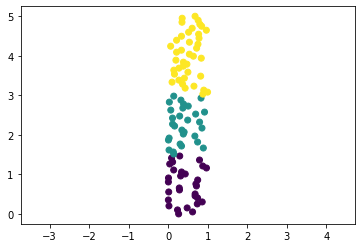

In [35]:
X=np.concatenate((np.random.random((100,1)),np.linspace(0,5,100)[:,None]),axis=1)
c=X[:,1].copy()
c[c<1.5]=0
c[(c!=0) & (c<=3)]=1
c[c>3]=2
plt.scatter(*X.T,c=c)
plt.axis('equal')

In [49]:
get_ps(adata)

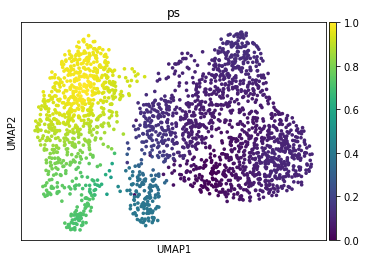

In [50]:
sc.pl.umap(adata,color='ps')

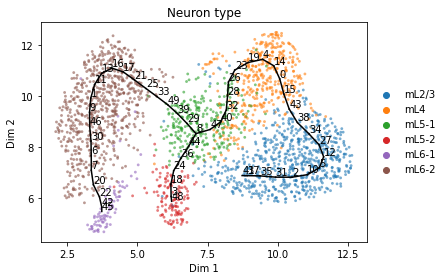

In [12]:
st2.pl.graph(adata,show_text=True,alpha=0.6,color=['Neuron type'])

In [15]:
st2.tl.add_loops(adata,inplace=False)


Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")

From root 31  to Terminal state 1 is found 15  times.
From root 31  to Terminal state 4 is found 113  times.
From root 31  to Terminal state 5 is found 40  times.
From root 31  to Terminal state 6 is found 99  times.
From root 31  to Terminal state 8 is found 33  times.
From root 31  to Terminal state 10 is found 10  times.
From root 31  to Terminal state 16 is found 243  times.
From root 31  to Terminal state 26 is found 232  times.
From root 31  to Terminal state 27 is found 34  times.
From root 31  to Terminal state 28 is found 5  times.
From root 31  to Terminal state 32 is found 34  times.
From root 31  to Terminal state 34 is found 5  times.
From root 31  to Terminal state 37 is found 24  times.
From root 31  to Terminal state 38 is found 17  times.
From root 31  to Terminal state 42 is found 126  times.
From root 31  to Terminal state 45 is found 11  times.
From root 31  to Terminal state 48 is found 104  times.
terminal clusters [1, 4, 5, 6, 8, 10, 16, 26, 27, 28, 32, 34, 37, 3

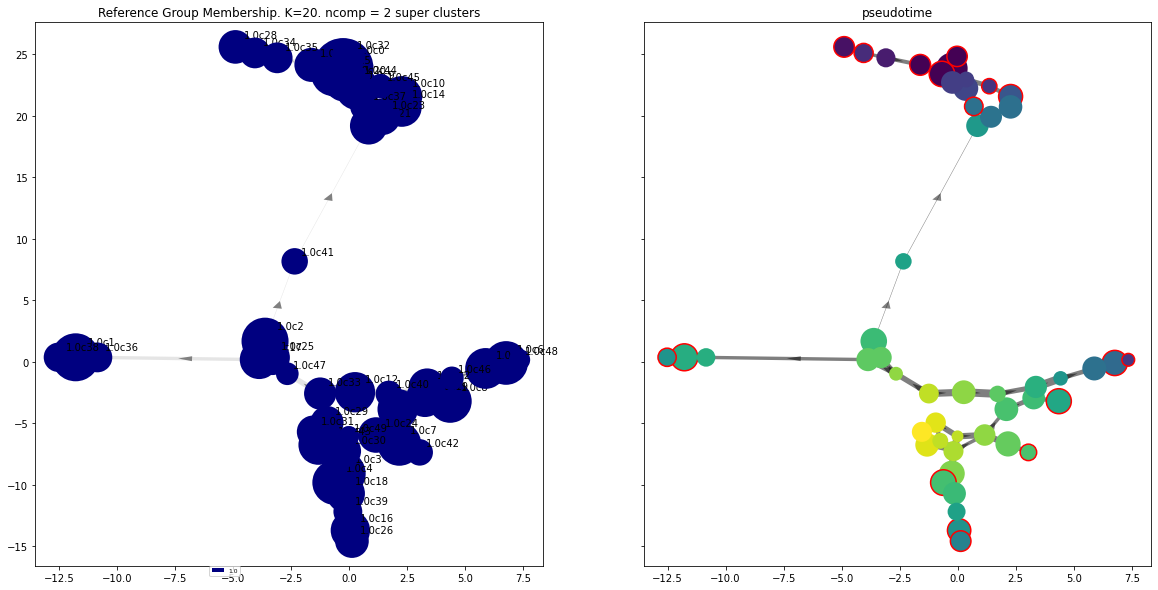

time elapsed 51.9 seconds
input data has shape 2278 (samples) x 2 (features)
time is Thu Dec 23 18:35:48 2021
commencing global pruning
Share of edges kept after Global Pruning 49.05 %
commencing community detection
time is Thu Dec 23 18:35:48 2021
59  clusters before handling small/big
There are 0 clusters that are too big
humanCD34 : global cluster graph pruning level 0.15
number of components before pruning 1
percentage links trimmed from local pruning relative to start 0.0
percentage links trimmed from global pruning relative to start 50.4
there are  1 components in the graph
root user [0]
start computing lazy-teleporting Expected Hitting Times
ended all multiprocesses, will retrieve and reshape
super_terminal_clusters [1, 4, 5, 6, 8, 10, 16, 26, 27, 28, 32, 34, 37, 38, 42, 45, 48]
terminal clus in this component [11, 4, 3, 7, 8, 10, 15, 28, 27, 29, 33, 36, 37, 38, 41, 45, 48]
final terminal clus [11, 4, 3, 7, 8, 10, 15, 28, 27, 29, 33, 36, 37, 38, 41, 45, 48]
From root 32  to Term

From root 32  to Terminal state 10 is found 20  times.
From root 32  to Terminal state 15 is found 241  times.
From root 32  to Terminal state 28 is found 238  times.
From root 32  to Terminal state 27 is found 5  times.
From root 32  to Terminal state 29 is found 5  times.
From root 32  to Terminal state 33 is found 11  times.
From root 32  to Terminal state 36 is found 5  times.
From root 32  to Terminal state 37 is found 26  times.
From root 32  to Terminal state 38 is found 10  times.
From root 32  to Terminal state 41 is found 116  times.
From root 32  to Terminal state 45 is found 22  times.
From root 32  to Terminal state 48 is found 113  times.
terminal clusters [11, 4, 3, 7, 8, 10, 15, 28, 27, 29, 33, 36, 37, 38, 41, 45, 48]
project onto single cell
start single cell projections of pseudotime and lineage likelihood
number of components before pruning 1
percentage links trimmed from local pruning relative to start 25.6
percentage links trimmed from global pruning relative to st

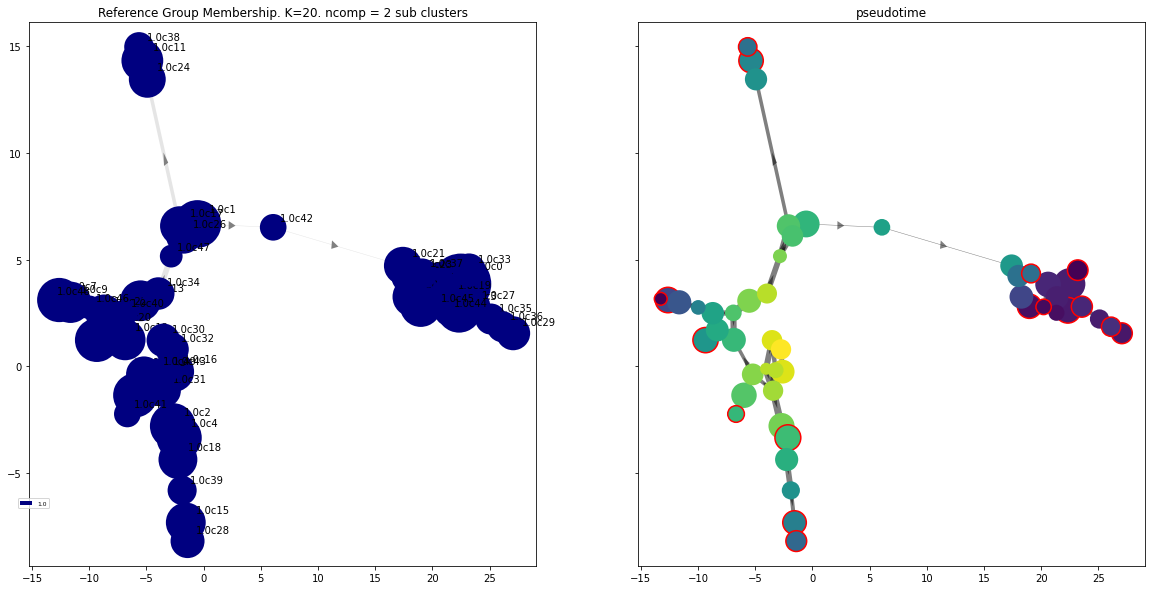

time elapsed 62.4 seconds
dict of terminal state pairs, Super: sub:  {1: 11, 4: 4, 5: 3, 6: 7, 8: 8, 10: 10, 16: 15, 26: 28, 27: 27, 28: 29, 32: 33, 34: 36, 37: 37, 38: 38, 42: 41, 45: 45, 48: 48}


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |#######################

super cluster 1 is a super terminal with sub_terminal cluster 11
super cluster 4 is a super terminal with sub_terminal cluster 4
super cluster 5 is a super terminal with sub_terminal cluster 3
super cluster 6 is a super terminal with sub_terminal cluster 7
super cluster 8 is a super terminal with sub_terminal cluster 8
super cluster 10 is a super terminal with sub_terminal cluster 10
super cluster 16 is a super terminal with sub_terminal cluster 15
super cluster 26 is a super terminal with sub_terminal cluster 28
super cluster 27 is a super terminal with sub_terminal cluster 27
super cluster 28 is a super terminal with sub_terminal cluster 29
super cluster 32 is a super terminal with sub_terminal cluster 33
super cluster 34 is a super terminal with sub_terminal cluster 36
super cluster 37 is a super terminal with sub_terminal cluster 37
super cluster 38 is a super terminal with sub_terminal cluster 38
super cluster 42 is a super terminal with sub_terminal cluster 41
super cluster 45 is

TypeError: cannot unpack non-iterable NoneType object

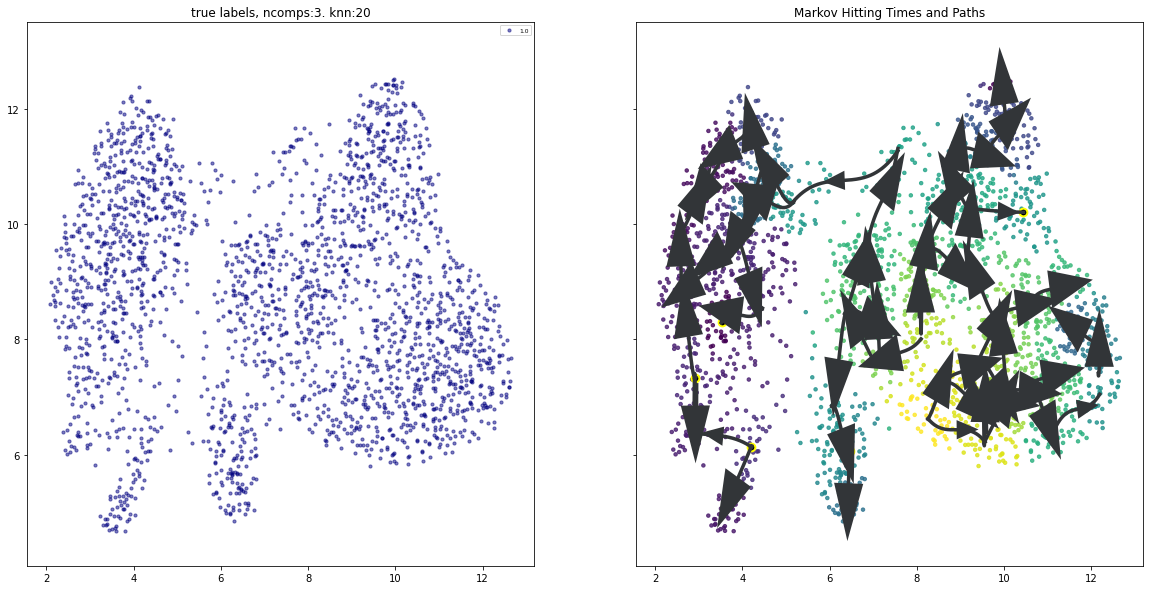

In [8]:
#default results
(slingshot_lineages, 
 mcle_nodep, mcle_stree, mcle_edges, 
 mcle_partitions, mcle_clusters) = run_monocle_slingshot_tuned(data_path, slingshot_ncenters = 50, 
                                                         mcle_ncenters = 50, mcle_sigma = 0.01, 
                                                         mcle_gamma = 0.5, mcle_eps = 1e-05,res_path='R_outputs/DNA/')

((via_out, via_projected_sc_pt, 
 (loci, c_edge, width_edge, pen_color, dot_size)),
 (via_out2, via_projected_sc_pt2,
 (loci2, c_edge2, width_edge2, pen_color2, dot_size2)),
 (via_out3, via_projected_sc_pt3,
 (loci3, c_edge3, width_edge3, pen_color3, dot_size3)),) = run_VIA(X,X,labels=None,root_user = [0], 
                                                            v0_too_big = 0.3 , v1_too_big = 0.1, v0_random_seed = 42, 
                                                            knn = 20,ncomps=2)

#((via_out_pca, via_projected_sc_pt_pca, 
# (loci_pca, c_edge_pca, width_edge_pca, pen_color_pca, dot_size_pca)),
# (via_out2_pca, via_projected_sc_pt2_pca,
# (loci2_pca, c_edge2_pca, width_edge2_pca, pen_color2_pca, dot_size2_pca)),
# (via_out3_pca, via_projected_sc_pt3_pca,
# (loci3_pca, c_edge3_pca, width_edge3_pca, pen_color3_pca, dot_size3_pca)),) = run_VIA(_anndata.obsm['X_pca'],X,labels=None,root_user = [0], 
#                                                            v0_too_big = 0.3 , v1_too_big = 0.1, v0_random_seed = 42, 
#                                                            knn = 20,ncomps=20)

paga_nodep, paga_edges, paga_weights = run_paga(_anndata,X,resolution=1)

In [42]:
merged_nodep=epg_nodep
merged_edges=epg_edges

In [10]:
epg_nodep, epg_edges, epg_pointweights = run_epg(adata,n_nodes=30,epg_alpha=0.02)

Seeding initial elastic principal graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...
Constructing tree 1 of 1 / Subset 1 of 1
Computing EPG with  30  nodes on  2278  points and  2  dimensions

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1|2||21	1.3523	21	20	12	2	0	0	0.7532	0.6909	0.9382	0.9433	0.4019	0.1972	4.1415	86.9719	0
1|2||22	1.2933	22	21	13	2	0	0	0.7357	0.6765	0.9396	0.9445	0.3891	0.1685	3.7079	81.5746	0
1|2||23	1.2367	23	22	14	2	0	0	0.7086	0.6499	0.9418	0.9467	0.3797	0.1483	3.4118	78.4719	0
1|2||24	1.1957	24	23	15	2	0	0	0.6885	0.6368	0.9435	0.9477	0.367	0.1402	3.3641	80.7386	0
1|2||25	1.1468	25	24	16	2	0	0	0.6639	0.6137	0.9455	0.9496	0.3582	0.1248	3.1202	78.0052	0
1|2||26	1.1049	26	25	17	2	0	0	0.6401	0.5906	0.9475	0.9515	0.3542	0.1106	2.8764	74.7869	0
1|2||27	1.0718	27	26	18	2	0	0	0.6226	0.5787	0.9489	0.9525	0.3435	0.1057	2.8526	77.021	0
1|2||28	1.0354	28	27	19	2	0	0	0.6052	0.5649	0.9503	0.9536	0.

IndexError: index 2 is out of bounds for axis 1 with size 2

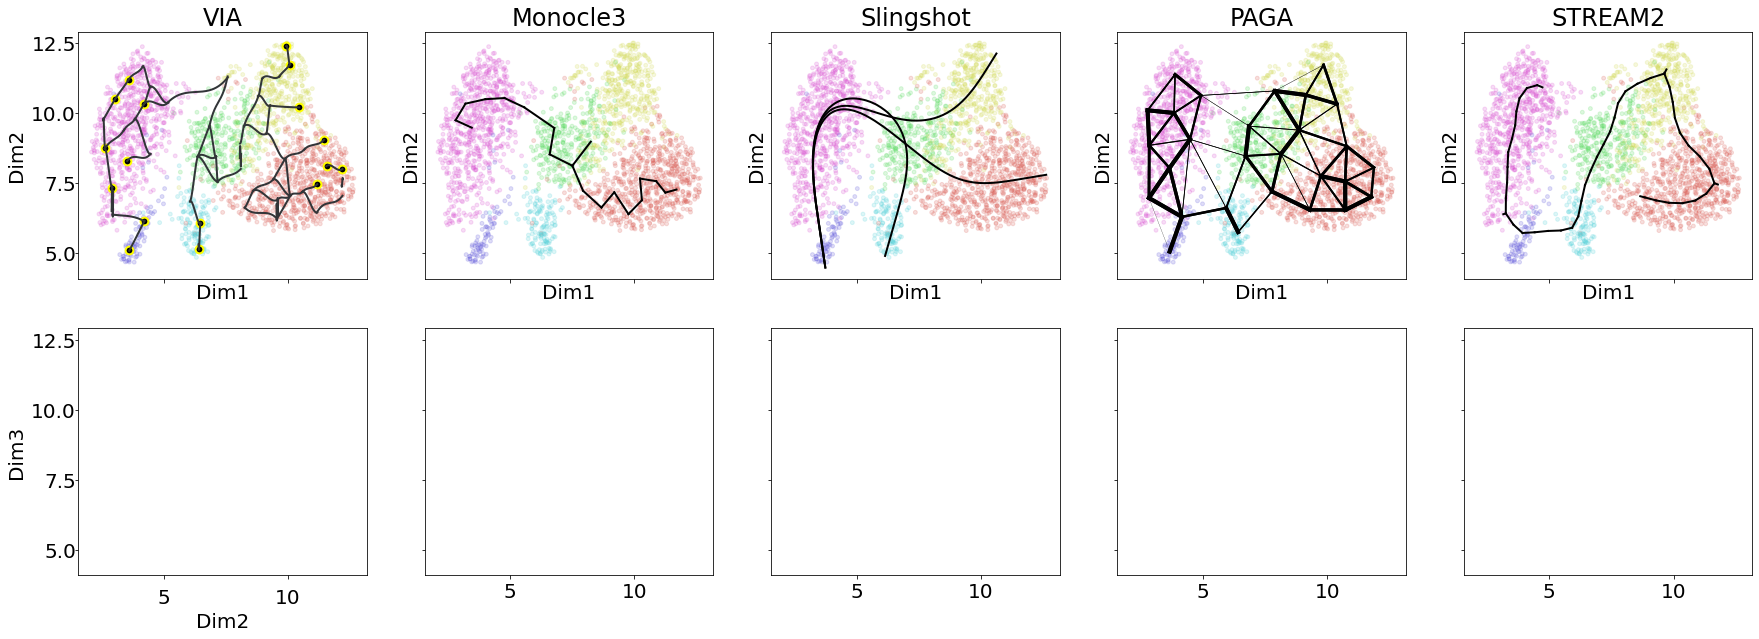

In [43]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(2,5,figsize=(30,10),sharey=True,sharex=True)
axs=axs.flat
X_plot=X
linewidth=2

def labels_to_color(labels):
    '''Turn a list of labels into a list of colors'''
    import seaborn as sns
    import matplotlib.patches as mpatches
    unique_labels = np.unique(labels)
    colors = sns.color_palette('hls', len(unique_labels))

    # Associate each sample with a color indicating its type
    idx = np.zeros(len(labels)).astype(int)
    legend = []
    for i in range(len(unique_labels)):
        idx[labels == unique_labels[i]] = i
        legend.append(mpatches.Patch(color=colors[i], label=unique_labels[i]))
                       
    col = [colors[i] for i in idx]
    return col, legend, unique_labels
c_plot, legend, unique_labels = labels_to_color(_anndata.obs['Neuron type'])

def init_subplot(d1=0,d2=2):
    ax = next(axs)
    ax.set_xlabel(f'Dim{d1+1}',labelpad=5)
    ax.set_ylabel(f'Dim{d2+1}',labelpad=5)
    ax.locator_params(axis='x',nbins=4)
    ax.locator_params(axis='y',nbins=4)
    ax.tick_params(axis="x",pad=10)
    ax.tick_params(axis="y",pad=-1)
    _=ax.scatter(X_plot[:,d1],X_plot[:,d2],c=c_plot,s=15,alpha=.2)
    return ax,_

for i0,(d1,d2) in enumerate(((0,1),(1,2))):

    #via
    ax,_=init_subplot(d1,d2)
    if i0==0: 
        ax.set_title('VIA')
        via_plot=via_out
        (loci_plot, c_edge_plot, width_edge_plot, pen_color_plot, dot_size_plot)=(loci, c_edge, width_edge,  pen_color, dot_size)
    else: 
        via_plot=via_out3
        (loci_plot, c_edge_plot, width_edge_plot, pen_color_plot, dot_size_plot)=(loci3, c_edge3, width_edge3, pen_color3, dot_size3)
    for i in range(len(via_out)): 
        ax.plot(via_plot[i][0], via_plot[i][1], linewidth=linewidth, c='#323538')#1.5

        direction_arrow=via_plot[i][2]; head_width=via_out[i][3]
        if direction_arrow == 1:
            ax.arrow(via_plot[i][4], via_plot[i][5], via_plot[i][6], via_plot[i][7], shape='full', lw=0, length_includes_head=False,
                      head_width=.03, color='#323538')  
    count_ = 0
    for i, c_e, w, pc, dsz in zip(loci, c_edge, width_edge, pen_color, dot_size):  # sc_supercluster_nn
        ax.scatter(X[i, d1], X[i, d2], c='black', s=dsz, edgecolors=c_e, linewidth=w)
        count_ = count_ + 1

    #monocle
    ax,_=init_subplot(d1,d2)
    if i0==0: ax.set_title('Monocle3')
    for e in mcle_edges:
        curve_i = np.concatenate((mcle_nodep[[e[0]]], mcle_nodep[[e[1]]]),axis=0).T
        ax.plot(curve_i[d1], curve_i[d2], c='k',linewidth=linewidth)

    #slingshot
    ax,_=init_subplot(d1,d2)
    if i0==0: ax.set_title('Slingshot')
    for l in slingshot_lineages['GMM']:
        curve_i = l.T
        ax.plot(curve_i[d1], curve_i[d2], c='k',linewidth=linewidth)

    #paga
    ax,_=init_subplot(d1,d2)
    if i0==0: ax.set_title('PAGA')
    for e,w in zip(paga_edges,paga_weights):
        curve_i = np.concatenate((paga_nodep[[e[0]]], paga_nodep[[e[1]]]),axis=0).T
        ax.plot(curve_i[d1], curve_i[d2], c='k',linewidth=2*linewidth*w)

    #epg
    ax,_=init_subplot(d1,d2)
    if i0==0: ax.set_title('STREAM2')
    for edge_i in merged_edges:
        curve_i = np.concatenate((merged_nodep[[edge_i[0]]], merged_nodep[[edge_i[1]]]),axis=0).T
        ax.plot(curve_i[d1], curve_i[d2], c='k',linewidth=linewidth)

#fig.tight_layout()
#fig.subplots_adjust(right=0.82)
fig.legend(legend, unique_labels, loc = 'center right')
plt.savefig('figures/dna_default_2d.png',dpi=300,bbox_inches='tight')

In [77]:
dis, idx = elpigraph_v2.ordinal_neighbors_reg(adata.obsm['X_umap'], 
                      stages_labels=adata.obs['Neuron type'], 
                      stages=['mL2/3', 'mL4', 'mL5-1', 'mL5-2', 'mL6-1','mL6-2', ], 
                      n_neighbors = 12, n_natural = 0, m = 'euclidean', method='force')
g=_longform_knn_to_sparse(dis,idx)

In [177]:
def _get_clus_adjmat2(adjmat_strength, num_modes, n_clusters):
    """ Create clus_adjmat given labels adjmat and kmeans label assignment."""

    adjmat_clus = np.ones((n_clusters, n_clusters))

    for ei in range(len(adjmat_strength)):
        for ej in range(len(adjmat_strength)):
            clus_ei = np.where(num_modes == ei)[0]
            clus_ej = np.where(num_modes == ej)[0]
            adjmat_clus[
                clus_ei[:, None], np.repeat(clus_ej[None], len(clus_ei), axis=0)
            ] = (1-factor)+adjmat_strength[ei,ej]*factor
    return adjmat_clus

In [236]:
X=adata.obsm['X_umap']
stages_labels=adata.obs['Neuron type']
stages=['mL2/3', 'mL4', 'mL5-1', 'mL5-2', 'mL6-1','mL6-2', ]
k = 15
m = 'euclidean'
radius=None
from scipy.sparse import csr_matrix

In [180]:
g=elpigraph_v2.ordinal_neighbors_stagewise(X, 
                              stages_labels=adata.obs['Neuron type'], 
                              stages=['mL2/3', 'mL4', 'mL5-1', 'mL5-2', 'mL6-1','mL6-2', ], 
                              k = 5, 
                              m = 'euclidean')
knn_distances, knn_idx = elpigraph_v2.ordinal_neighbors_stagewise_longform(X, 
                                                              stages_labels=adata.obs['Neuron type'], 
                                                              stages=['mL2/3', 'mL4', 'mL5-1', 'mL5-2', 'mL6-1','mL6-2', ], 
                                                              k = 5, 
                                                              m = 'euclidean')
g2=_longform_knn_to_sparse(knn_distances,knn_idx)
adata.obs['ps']=geodesic_pseudotime(X,k,root=0,g=g2)

In [3]:
paths=['mL2/3', 'mL4', 'mL5-1', 'mL5-2', 'mL6-1', 'mL6-2']
paths_forbidden=[]
labels=adata.obs['Neuron type']
num_labels = {s: i for i, s in enumerate(stages)}
num_stages = np.array([num_labels[s] for s in labels])

NameError: name 'stages' is not defined

In [219]:
labels_u = np.unique([c for p in paths for c in p])
labels_ignored = np.setdiff1d(labels, labels_u)
# label adjacency matrix
adjmat, num_labels = _get_labels_adjmat2(labels_u, labels_ignored, paths, paths_forbidden)
graph = nx.from_numpy_matrix(adjmat)
adjmat_strength = np.array(pd.DataFrame(dict(nx.all_pairs_shortest_path_length(graph))))
max_shortestpath = np.nanmax(adjmat_strength)
adjmat_strength = adjmat_strength / max_shortestpath  
adjmat_strength[np.isnan(adjmat_strength)] = 1

In [229]:
def _categorical_adjmat2(mat, init_nodes_pos, paths, paths_forbidden, labels, n_neighbors=10):
    """ Main function, create categorical adjmat given node positions, cluster paths, point labels"""

    labels_u = np.unique([c for p in paths for c in p])
    labels_ignored = np.setdiff1d(labels, labels_u)
    # label adjacency matrix
    adjmat, num_labels = _get_labels_adjmat2(labels_u, labels_ignored, paths, paths_forbidden)

    graph = nx.from_numpy_matrix(adjmat)
    adjmat_strength = np.array(pd.DataFrame(dict(nx.all_pairs_shortest_path_length(graph))))
    max_shortestpath = np.nanmax(adjmat_strength)
    adjmat_strength = adjmat_strength / max_shortestpath  
    adjmat_strength[np.isnan(adjmat_strength)] = 1

    # assign label to nodes
    num_modes = np.array([num_labels[m] for m in labels])

    # nodes adjacency matrix
    clus_adjmat = _get_clus_adjmat2(adjmat_strength, num_modes, n_clusters=len(init_nodes_pos))
    return init_nodes_pos, clus_adjmat, adjmat, adjmat_strength, num_modes, num_labels, labels_ignored

In [230]:
factor=.99
(init_nodes_pos, 
 clus_adjmat, adjmat, adjmat_strength, 
 num_modes, num_labels, labels_ignored) = _categorical_adjmat2(X, X, paths, paths_forbidden, labels, n_neighbors=10)
#D = pairwise_distances(init_nodes_pos)
G = nx.from_numpy_matrix(D * clus_adjmat)

ValueError: operands could not be broadcast together with shapes (15,15) (2278,2278) 

In [ ]:
sup(X_elpi,pseudotime,.1)

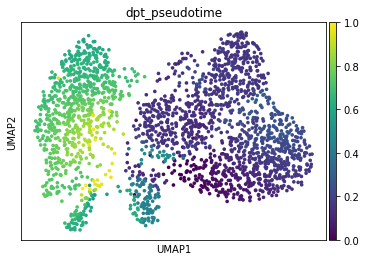

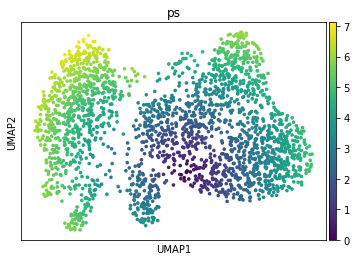

In [182]:
dpt2(adata,stages_labels=adata.obs['Neuron type'], 
          stages=['mL2/3', 'mL4', 'mL5-1', 'mL5-2', 'mL6-1','mL6-2', ],
    obsm='X_umap',iroot=0,n_neighbors=60,n_natural=0,m='euclidean',method='force',mode='distance')
sc.pl.umap(adata,color='dpt_pseudotime')
sc.pl.umap(adata,color='ps')

In [57]:
labels=adata.obs['Neuron type']
stages=['mL2/3', 'mL4', 'mL5-1', 'mL5-2', 'mL6-1','mL6-2', ]
num_labels = {s: i for i, s in enumerate(stages)}
num_stages = np.array([num_labels[s] for s in labels])

x=np.array(adata.obs['Neuron type'])[idx]
for i in range(len(x)):
    for j in range(x.shape[1]):
        x[i,j]=num_labels[x[i,j]]
x=x.astype(int)

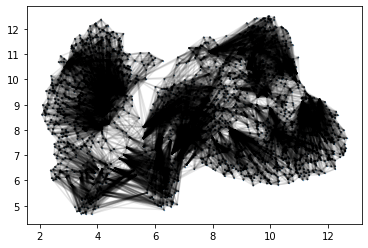

In [73]:
X=adata.obsm['X_umap']
plt.scatter(*X.T,s=.1)
for i,nn in enumerate(idx):
    for k in nn:
        plt.plot([X[i,0],X[k,0]],[X[i,1],X[k,1]],alpha=.1,c='k')

In [40]:
from sklearn.cluster import SpectralClustering, AffinityPropagation, KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances, euclidean_distances
import elpigraph 
import scipy

def _force_missing_connections(D,num_labels,num_modes,init_edges):
    found_missing = True
    while found_missing:

        found_missing = False
        edges_labels = np.array(list(num_labels.keys()))[num_modes][init_edges].tolist() 
        for path in paths:
            for i in range(len(path)-1):
                if [path[i],path[i+1]] not in edges_labels and [path[i+1],path[i]] not in edges_labels:
                    print(path[i],path[i+1])
                    print(num_labels[path[i]],num_labels[path[i+1]])

                    missing_is = np.where(num_modes==num_labels[path[i]])[0]
                    missing_js = np.where(num_modes==num_labels[path[i+1]])[0]
                    x = D[missing_is[:,None],missing_js]
                    _i,_j = np.where(x == x.min())
                    mi,mj = missing_is[_i],missing_js[_j]
                    D[mi,mj] = D[mj,mi] = -1.
                    found_missing = True

        # ---get edges from mst
        G = nx.from_numpy_matrix(D * clus_adjmat)
        mst = nx.minimum_spanning_tree(G, ignore_nan=True)
        init_edges = np.array(mst.edges())
    return init_edges

def _get_partition_modes(mat,init_nodes_pos,labels):
    ''' Return most frequent label assigned to each node '''
    labels = np.array(labels)
    part = elpigraph.src.core.PartitionData(mat,init_nodes_pos,10**6,np.sum(mat**2,axis=1,keepdims=1))[0].flatten()
    modes = np.empty(len(init_nodes_pos),dtype=labels.dtype)
    
    for i in range(len(init_nodes_pos)):
        modes[i] = scipy.stats.mode(labels[part==i]).mode[0]
    return modes

def _get_labels_adjmat(labels_u, labels_ignored, paths, paths_forbidden):
    """ Create adjmat given labels and paths. labels_ignored are connected to all other labels """
    num_labels = {s: i for i, s in enumerate(np.append(labels_u, labels_ignored))}
    adjmat = np.zeros(
        (len(labels_u) + len(labels_ignored), len(labels_u) + len(labels_ignored)),
        dtype=int,
    )
    
    # allow within-cluster connections
    np.fill_diagonal(adjmat, 1)
    
    # allow connections given from paths
    for p in paths:
        for i in range(len(p) - 1):
            adjmat[num_labels[p[i]], num_labels[p[i + 1]]] = adjmat[
                num_labels[p[i + 1]], num_labels[p[i]]
            ] = 1

    # allow unspecified clusters to connect to all other clusters
    for l in labels_ignored:
        adjmat[num_labels[l]] = adjmat[:, num_labels[l]] = 1
        
    # remove forbidden connections given from paths_forbidden
    for p in paths_forbidden:
        for i in range(len(p) - 1):
            adjmat[num_labels[p[i]], num_labels[p[i + 1]]] = adjmat[
                num_labels[p[i + 1]], num_labels[p[i]]
            ] = 0
            
    return adjmat, num_labels


def _get_clus_adjmat(adjmat, num_modes, n_clusters):
    """ Create clus_adjmat given labels adjmat and kmeans label assignment."""

    adjmat_clus = np.full((n_clusters, n_clusters), np.nan)
    eis, ejs = adjmat.nonzero()

    for ei, ej in zip(eis, ejs):
        clus_ei = np.where(num_modes == ei)[0]
        clus_ej = np.where(num_modes == ej)[0]
        adjmat_clus[
            clus_ei[:, None], np.repeat(clus_ej[None], len(clus_ei), axis=0)
        ] = 1
    return adjmat_clus


def _categorical_adjmat(mat, init_nodes_pos, paths, paths_forbidden, labels, n_neighbors=10):
    """ Main function, create categorical adjmat given node positions, cluster paths, point labels"""

    labels_u = np.unique([c for p in paths for c in p])
    labels_ignored = np.setdiff1d(labels, labels_u)
    # label adjacency matrix
    adjmat, num_labels = _get_labels_adjmat(labels_u, labels_ignored, paths, paths_forbidden)
    # assign label to nodes
    modes = _get_partition_modes(mat,init_nodes_pos,labels)
    num_modes = np.array([num_labels[m] for m in modes])

    # add centroids if necessary to prevent bug (if some label has no kmean assigned to it)
    labels_miss = np.setdiff1d(labels_u, modes)
    if len(labels_miss) > 0:
        print(
            f"Found label(s) {labels_miss} with no representative node. Adding label centroid(s) as node(s)"
        )
        centroids = np.vstack([mat[labels == s].mean(axis=0) for s in labels_miss])
        init_nodes_pos = np.vstack((init_nodes_pos, centroids))
        modes = np.hstack((modes, labels_miss))
        num_modes = np.array([num_labels[m] for m in modes])

    # nodes adjacency matrix
    clus_adjmat = _get_clus_adjmat(adjmat, num_modes, n_clusters=len(init_nodes_pos))
    return init_nodes_pos, clus_adjmat, adjmat, num_modes, num_labels

clustering="kmeans"
key="seed_epg"
adata.uns[key]={}
mat=adata.obsm['X_dr']
n_clusters=15
force=False
labels = 'Neuron type'
paths = [
    ['7','0','1','3','4','6'],
    ['7','0','1','2','8'],
    ['7','0','1'],
]
paths = [
    ['mL2/3', 'mL4', 'mL5-1', 'mL5-2', 'mL6-1', ]
]
paths_forbidden = [['mL6-2','mL6-1']]

#paths_forbidden=[]

# kmeans stuff
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42).fit(mat,sample_weight = None)
cluster_labels = kmeans.labels_
init_nodes_pos = kmeans.cluster_centers_
adata.obs[clustering] = ["cluster " + str(x) for x in cluster_labels]

### Minimum Spanning Tree ###
print("Calculating minimum spanning tree...")

# ---if supervised adjacency matrix option
if (len(paths) > 0 and labels is None) or (len(paths) == 0 and labels is not None):
    raise ValueError(
        "Both a label key (labels: str) and cluster paths (paths: list of list) need to be provided for path-supervised initialization"
    )
elif len(paths) > 0 and labels is not None:
    init_nodes_pos, clus_adjmat, adjmat, num_modes, num_labels = _categorical_adjmat(
        mat, init_nodes_pos, paths, paths_forbidden, adata.obs[labels], n_neighbors=10
    )
    D = pairwise_distances(init_nodes_pos)
    G = nx.from_numpy_matrix(D * clus_adjmat)

# ---else unsupervised
else:
    D = pairwise_distances(init_nodes_pos)
    G = nx.from_numpy_matrix(D)

# ---get edges from mst
mst = nx.minimum_spanning_tree(G, ignore_nan=True)
init_edges = np.array(mst.edges())

if force:
    init_edges = _force_missing_connections(D,num_labels,num_modes,init_edges)

adata.uns[key]["node_pos"]=init_nodes_pos

Calculating minimum spanning tree...


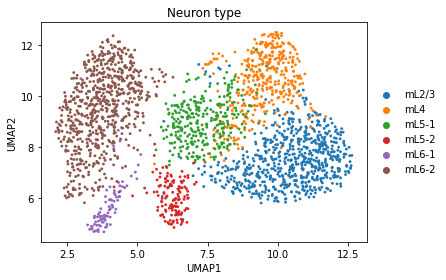

In [5]:
st2.pl.umap(adata,color=['Neuron type'])

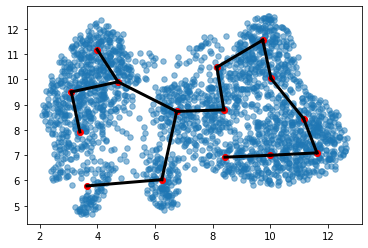

In [6]:
plt.scatter(*adata.obsm['X_dr'].T,s=30,alpha=.5)
plt.scatter(*init_nodes_pos.T,c='r')
#plt.scatter(*init_nodes_pos[n_clusters-len(labels_miss):].T,c='k')

for edge_i in init_edges:
    curve_i = np.concatenate((init_nodes_pos[[edge_i[0]]], init_nodes_pos[[edge_i[1]]]),axis=0).T
    plt.plot(curve_i[0], curve_i[1], c='k',linewidth=3)

In [77]:
haisu=Haisu.HAISU(['mL2/3', 'mL4', 'mL5-1', 'mL5-2', 'mL6-1',],adjmat[:-1,:-1])

In [11]:
sys.path.append('../../git/Haisu/')
import Haisu
labels_num = {v:k for k,v in num_labels.items()}
modes_labels = np.array([labels_num[m] for m in num_modes])
np.fill_diagonal(adjmat,0)
g=nx.from_numpy_matrix(adjmat)
haisu=Haisu.HAISU(['mL2/3', 'mL4', 'mL5-1', 'mL5-2', 'mL6-1','mL6-2'],adjmat[:-1,:-1])
D = haisu.get_pairwise_matrix(init_nodes_pos.T, modes_labels, factor=.99, metric='euclidean', n_jobs=1)
G = nx.from_numpy_matrix(D)
mst = nx.minimum_spanning_tree(G, ignore_nan=True)
init_edges = np.array(mst.edges())

X.shape (2, 15)
len(ylabels) 15


In [13]:
def _get_labels_adjmat2(labels_u, labels_ignored, paths, paths_forbidden):
    """ Create adjmat given labels and paths. labels_ignored are connected to all other labels """
    num_labels = {s: i for i, s in enumerate(np.append(labels_u, labels_ignored))}
    len_labels = len(labels_u) + len(labels_ignored)
    adjmat = np.zeros((len_labels, len_labels))
    
    # allow within-cluster connections
    np.fill_diagonal(adjmat, 1)
    
    # allow connections given from paths
    for p in paths:
        for i in range(len(p) - 1):
            adjmat[num_labels[p[i]], num_labels[p[i + 1]]] = adjmat[
                num_labels[p[i + 1]], num_labels[p[i]]
            ] = 1

    # disallow unspecified clusters to connect to all other clusters
    for l in labels_ignored:
        adjmat[num_labels[l]] = adjmat[:, num_labels[l]] = 0
        adjmat[num_labels[l],num_labels[l]] = 1
        
    # remove forbidden connections given from paths_forbidden
    for p in paths_forbidden:
        for i in range(len(p) - 1):
            adjmat[num_labels[p[i]], num_labels[p[i + 1]]] = adjmat[
                num_labels[p[i + 1]], num_labels[p[i]]
            ] = np.nan
            
    return adjmat, num_labels

def _get_clus_adjmat2(adjmat_strength, num_modes, n_clusters):
    """ Create clus_adjmat given labels adjmat and kmeans label assignment."""

    adjmat_clus = np.ones((n_clusters, n_clusters))

    for ei in range(len(adjmat_strength)):
        for ej in range(len(adjmat_strength)):
            clus_ei = np.where(num_modes == ei)[0]
            clus_ej = np.where(num_modes == ej)[0]
            adjmat_clus[
                clus_ei[:, None], np.repeat(clus_ej[None], len(clus_ei), axis=0)
            ] = (1-factor)+adjmat_strength[ei,ej]*factor
    return adjmat_clus

def _categorical_adjmat2(mat, init_nodes_pos, paths, paths_forbidden, labels, n_neighbors=10):
    """ Main function, create categorical adjmat given node positions, cluster paths, point labels"""

    labels_u = np.unique([c for p in paths for c in p])
    labels_ignored = np.setdiff1d(labels, labels_u)
    # label adjacency matrix
    adjmat, num_labels = _get_labels_adjmat2(labels_u, labels_ignored, paths, paths_forbidden)

    ix_nan = np.isnan(adjmat)
    adjmat[ix_nan] = 0.
    graph = nx.from_numpy_matrix(adjmat)
    adjmat_strength = np.array(pd.DataFrame(dict(nx.all_pairs_shortest_path_length(graph))))
    max_shortestpath, min_shortestpath = np.nanmax(adjmat_strength), 1.
    #np.fill_diagonal(adjmat_strength, min_shortestpath)
    adjmat_strength = adjmat_strength / max_shortestpath  
    adjmat_strength[np.isnan(adjmat_strength) & (~ix_nan)] = 1.

    # assign label to nodes
    modes = _get_partition_modes(mat,init_nodes_pos,labels)
    num_modes = np.array([num_labels[m] for m in modes])

    # add centroids if necessary to prevent bug (if some label has no kmean assigned to it)
    labels_miss = np.setdiff1d(labels_u, modes)
    if len(labels_miss) > 0:
        print(
            f"Found label(s) {labels_miss} with no representative node. Adding label centroid(s) as node(s)"
        )
        centroids = np.vstack([mat[labels == s].mean(axis=0) for s in labels_miss])
        init_nodes_pos = np.vstack((init_nodes_pos, centroids))
        modes = np.hstack((modes, labels_miss))
        num_modes = np.array([num_labels[m] for m in modes])

    # nodes adjacency matrix
    clus_adjmat = _get_clus_adjmat2(adjmat_strength, num_modes, n_clusters=len(init_nodes_pos))
    return init_nodes_pos, clus_adjmat, adjmat, adjmat_strength, num_modes, num_labels, labels_ignored

In [41]:
paths=[['mL2/3', 'mL4', 'mL5-1','mL5-2', 'mL6-1',]]
paths=[]
paths_forbidden=[['mL6-2', 'mL6-1']]
#paths_forbidden=[]

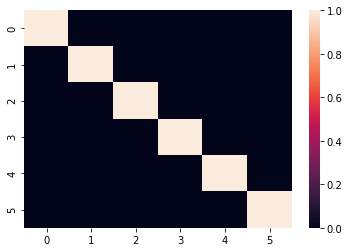

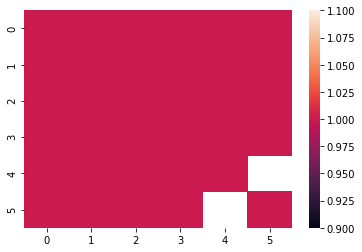

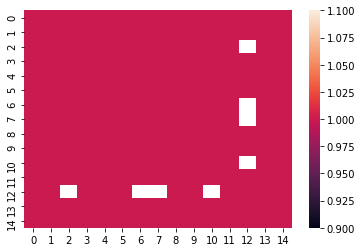

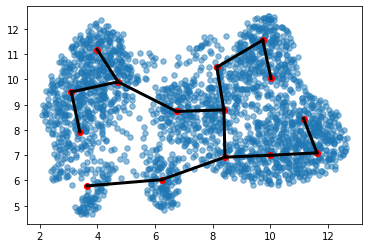

In [42]:
factor=.999999999999
(init_nodes_pos, 
 clus_adjmat, adjmat, adjmat_strength, 
 num_modes, num_labels, labels_ignored) = _categorical_adjmat2(mat, init_nodes_pos, paths, paths_forbidden, adata.obs['Neuron type'], n_neighbors=10)

num_labels_ignored = np.array([num_labels[m] for m in labels_ignored])
D = pairwise_distances(init_nodes_pos)
G = nx.from_numpy_matrix(D * clus_adjmat)
# ---get edges from mst
mst = nx.minimum_spanning_tree(G, ignore_nan=True)
init_edges = np.array(mst.edges())

adata.uns[key]["node_pos"]=init_nodes_pos

import seaborn as sns
sns.heatmap(adjmat);plt.show()
sns.heatmap(adjmat_strength);plt.show()
sns.heatmap(clus_adjmat);plt.show()

plt.scatter(*adata.obsm['X_dr'].T,s=30,alpha=.5)
plt.scatter(*init_nodes_pos.T,c='r')
#plt.scatter(*init_nodes_pos[n_clusters-len(labels_miss):].T,c='k')

for edge_i in init_edges:
    curve_i = np.concatenate((init_nodes_pos[[edge_i[0]]], init_nodes_pos[[edge_i[1]]]),axis=0).T
    plt.plot(curve_i[0], curve_i[1], c='k',linewidth=3)

In [ ]:
paths = [
    ['7','0','1','3','4','6'],
    ['7','0','1','2','8'],
    ['7','0','1'],
]

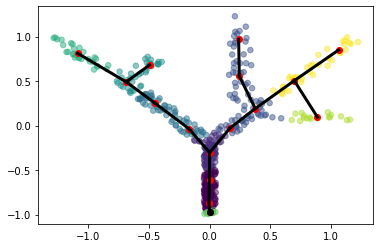

In [487]:
plt.scatter(*adata.X.T,c=np.array([num_labels[l] for l in labels]),s=30,alpha=.5)
plt.scatter(*init_nodes_pos.T,c='r')
plt.scatter(*init_nodes_pos[n_clusters-len(labels_miss):].T,c='k')

for edge_i in epg_edges:
    curve_i = np.concatenate((epg_nodes_pos[[edge_i[0]]], epg_nodes_pos[[edge_i[1]]]),axis=0).T
    plt.plot(curve_i[0], curve_i[1], c='k',linewidth=3)

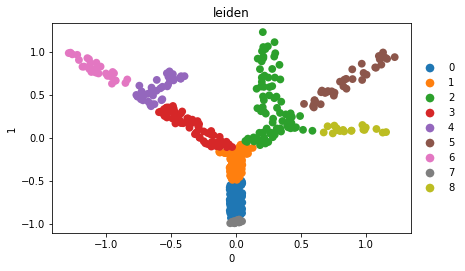

In [459]:
sc.pl.scatter(adata,x='0',y='1',color='leiden')

In [519]:
m='euclidean'
k=15


g=elpigraph_v2.ordinal_neighbors(adata.obsm[obsm],
                               stages_labels=stages_labels,
                               stages=stages,k=k,m=m)
g.eliminate_zeros()

adata.obsp['ordinal_distances'], adata.obsp['ordinal_connectivities'] = g, g
adata.uns['ordinal_neighbors'] = {'connectivities_key': 'ordinal_connectivities', 'distances_key': 'ordinal_distances', 
                                 'params': {'n_neighbors': k, 'method': 'umap', 'random_state': 0, 'metric': m,'n_pcs': 50}}

adata.uns['iroot'] = 0
dpt=sc.tools._dpt.DPT(adata,neighbors_key='ordinal_neighbors')
dpt._connectivities=adata.obsp['ordinal_connectivities']
dpt.compute_transitions(density_normalize=False)
dpt.compute_eigen()
adata.obsm['X_diffmap'] = dpt.eigen_basis
adata.uns['diffmap_evals'] = dpt.eigen_values

IndentationError: unexpected indent (<ipython-input-519-ea8406e17942>, line 5)

In [516]:
adata.uns['iroot'] = 474
m='euclidean'
k=50
g=elpigraph_v2.ordinal_neighbors(adata.obsm['X_dr'],
                               stages_labels=adata.obs['Neuron type'],
                               stages=['mL2/3', 'mL4', 'mL5-1', 'mL5-2', 'mL6-1', 'mL6-2'][::-1],k=k,m=m)

adata.obsp['ordinal_distances'], adata.obsp['ordinal_connectivities'] = g, g
adata.uns['ordinal_neighbors'] = {'connectivities_key': 'ordinal_connectivities', 'distances_key': 'ordinal_distances', 
                                 'params': {'n_neighbors': k, 'method': 'umap', 'random_state': 0, 'metric': m,'n_pcs': 50}}
del adata.obsp
del adata.uns['diffmap_evals']
del adata.obs['dpt_pseudotime']
del adata.obsm['X_diffmap']
#sc.tl.diffmap(adata,neighbors_key='ordinal_neighbors')
sc.tl.dpt(adata,neighbors_key='ordinal_neighbors')

AttributeError: 'NoneType' object has no attribute 'sum'

In [241]:
adata.obs['pseudotime']=geodesic_pseudotime(X=adata.obsm['X_umap'],k=k,root=adata.uns['iroot'],g=connectivities)

In [245]:
m='euclidean'
k=50
g=elpigraph_v2.ordinal_neighbors(adata.obsm['X_umap'],
                               stages_labels=adata.obs['Neuron type'],
                               stages=['mL2/3', 'mL4', 'mL5-1', 'mL5-2', 'mL6-1', 'mL6-2'][::-1],k=k,m=m)
adata.obs['pseudotime']=geodesic_pseudotime(X=adata.obsm['X_umap'],k=k,root=adata.uns['iroot'],g=g)

In [255]:
adata.obs['pseudotime']=geodesic_pseudotime(X=adata.obsm['X_pca'],k=k,root=adata.uns['iroot'],g=g)

In [262]:
adata.obsm['X_dr']=adata.obsm['X_umap']

In [285]:
elpigraph_v2.elastic_principal_graph_v2(adata,epg_n_nodes=80,epg_alpha=.1,                                     
                                        MaxNumberOfGraphCandidatesDict={'AddNode2Node': 0, 'BisectEdge': 10, 'ShrinkEdge':0},
                                        epg_pseudotime=adata.obs['pseudotime'].to_numpy(),
                                        epg_pseudotimeLambda=.5,
                                        epg_FixNodesAtPoints=[[474]],verbose=1)

No initial structure is seeded
Learning elastic principal graph...
Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  80  nodes on  2278  points and  2  dimensions

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||4	26.5867	4	3	2	0	0	0	3.0419	2.8566	0.669	0.6892	0.2829	23.2619	93.0476	372.1905	0
0||5	35.2107	5	4	3	0	0	0	2.6733	2.4758	0.7091	0.7306	0.3015	32.2358	161.1792	805.8959	0
0||6	34.6278	6	5	4	0	0	0	2.1202	1.9452	0.7693	0.7883	0.3068	32.2008	193.2047	1159.2281	0
0||7	41.9091	7	6	5	0	0	0	1.9796	1.8113	0.7846	0.8029	0.3096	39.6199	277.3394	1941.3761	0
0||8	42.7422	8	7	6	0	0	0	1.6269	1.4942	0.823	0.8374	0.3028	40.8125	326.5003	2612.0025	0
0||9	48.4937	9	8	7	0	0	0	1.4237	1.3182	0.8451	0.8566	0.2887	46.7813	421.03

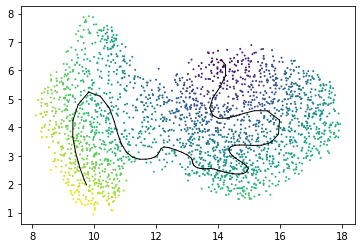

In [288]:
ax=plt.subplot()
plt.scatter(*adata.obsm['X_dr'].T,s=1,c=adata.obs['pseudotime'])
epg_nodep=adata.uns['epg_obj'][0]['NodePositions']
epg_edges=adata.uns['epg_obj'][0]['Edges'][0]
for edge_i in epg_edges:
    curve_i = np.concatenate((epg_nodep[[edge_i[0]]], epg_nodep[[edge_i[1]]]),axis=0).T
    ax.plot(curve_i[0], curve_i[1], c='k',linewidth=1)

In [70]:
import plotly.express as px
fig=px.scatter(x=adata.obsm['X_dr'][:,0],y=adata.obsm['X_dr'][:,1],hover_data={'idx':np.arange(len(adata))})
fig.write_html('x.html')

In [520]:
adata=sc.AnnData(X)
adata.obsm['X']=X
adata.obs['annot']=c.astype(int).astype(str)

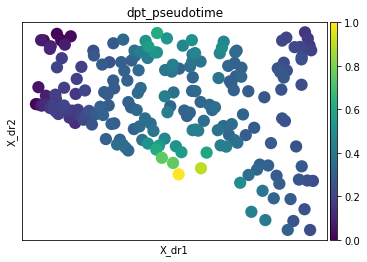

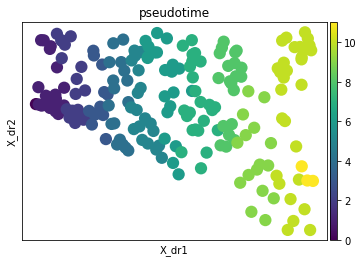

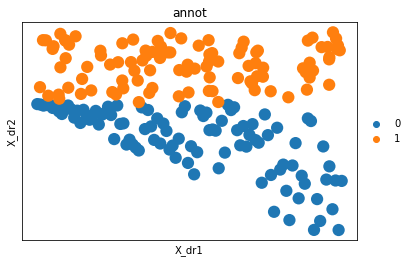

In [562]:
sc.pl.embedding(adata,basis="X_dr",color='dpt_pseudotime')
sc.pl.embedding(adata,basis="X_dr",color='pseudotime')
sc.pl.embedding(adata,basis="X_dr",color='annot')

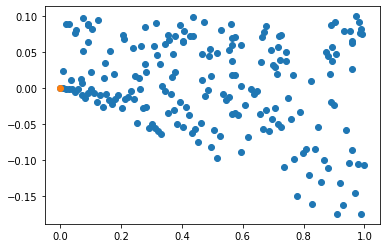

In [555]:
plt.scatter(*X.T)
plt.scatter(*X[[0]].T)

In [ ]:
def get_ps(adata, mat, root, stages_labels, stages=None, n_neighbors=60, n_natural=0, metric='euclidean',method='guide'):

    adata.uns['iroot'] = root
    
    g=elpigraph.utils.supervised_knn(mat,stages_labels=stages_labels,
                                    stages=stages,n_natural=n_natural,
                                    n_neighbors=n_neighbors,m=metric,method=method,
                                    return_sparse=True)
    
    g=(g+g.T)/2
    adata.obsp['distances'], adata.obsp['connectivities'] = g, g
    adata.uns['neighbors'] = {'connectivities_key': 'connectivities', 'distances_key': 'distances', 
                                     'params': {'n_neighbors': n_neighbors, 'method': 'umap', 'random_state': 0, 'metric': metric,'n_pcs': 50}}

    sc.tl.diffmap(adata)
    sc.tl.dpt(adata)
    adata.obs['ps'] = adata.obs['dpt_pseudotime'].copy()
    del adata.uns['diffmap_evals']
    del adata.obs['dpt_pseudotime']
    del adata.obsm['X_diffmap']

In [559]:
m='euclidean'
k=10
g=ordinal_neighbors_stagewise(adata.obsm['X_dr'],
                               stages_labels=adata.obs['annot'],
                               stages=['0','1'],k=k,m=m)
adata.obs['pseudotime']=geodesic_pseudotime(X=adata.obsm['X_dr'],k=k,root=adata.uns['iroot'],g=g)

In [554]:
adata.obsm['X_dr']=adata.X
adata.uns['iroot'] = 0
m='euclidean'
k=10
g=ordinal_neighbors_stagewise(adata.obsm['X_dr'],
                               stages_labels=adata.obs['annot'],
                               stages=['0','1'],k=k,m=m)

adata.obsp['distances'], adata.obsp['connectivities'] = g.copy(), g.copy()
adata.uns['neighbors'] = {'connectivities_key': 'connectivities', 'distances_key': 'distances', 
                                 'params': {'n_neighbors': k, 'method': 'umap', 'random_state': 0, 'metric': m,'n_pcs': 50}}
del adata.obsm['X_diffmap']
sc.tl.diffmap(adata)
sc.tl.dpt(adata)

In [304]:
adata.uns['iroot'] = 474
m='euclidean'
k=50
g=elpigraph_v2.ordinal_neighbors(adata.obsm['X_dr'],
                               stages_labels=adata.obs['Neuron type'],
                               stages=['mL2/3', 'mL4', 'mL5-1', 'mL5-2', 'mL6-1', 'mL6-2'][::-1],k=k,m=m)

adata.obsp['ordinal_distances'], adata.obsp['ordinal_connectivities'] = g, g
adata.uns['ordinal_neighbors'] = {'connectivities_key': 'ordinal_connectivities', 'distances_key': 'ordinal_distances', 
                                 'params': {'n_neighbors': k, 'method': 'umap', 'random_state': 0, 'metric': m,'n_pcs': 50}}
del adata.obsp
del adata.uns['diffmap_evals']
del adata.obs['dpt_pseudotime']
del adata.obsm['X_diffmap']
sc.tl.diffmap(adata,neighbors_key='ordinal_neighbors')
sc.tl.dpt(adata,neighbors_key='ordinal_neighbors')

KeyError: 'Neuron type'

In [144]:
adata.uns['iroot'] = 474
m='euclidean'
k=15
g=elpigraph_v2.ordinal_neighbors(adata.obsm['X_dr'],
                               stages_labels=adata.obs['Neuron type'],
                               stages=['mL2/3', 'mL4', 'mL5-1', 'mL5-2', 'mL6-1', 'mL6-2'][::-1],k=k,m=m)
g.eliminate_zeros()

adata.obsp['ordinal_distances'], adata.obsp['ordinal_connectivities'] = g, g
adata.uns['ordinal_neighbors'] = {'connectivities_key': 'ordinal_connectivities', 'distances_key': 'ordinal_distances', 
                                 'params': {'n_neighbors': k, 'method': 'umap', 'random_state': 0, 'metric': m,'n_pcs': 50}}

adata._connectivities=adata.obsp['ordinal_connectivities']
dpt=sc.tools._dpt.DPT(adata,neighbors_key='ordinal_neighbors')
dpt.compute_transitions(density_normalize=False)
dpt.compute_eigen()
adata.obsm['X_diffmap'] = dpt.eigen_basis
adata.uns['diffmap_evals'] = dpt.eigen_values
sc.tl.dpt(adata,neighbors_key='ordinal_neighbors')

In [63]:

import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scanpy as sc
from sklearn.neighbors import KNeighborsRegressor


class Pseudotime_calculator():
    """
    This is a custom object for pseudotime calculation.
    """
    def __init__(self, oracle_object=None, adata=None, obsm_key=None, cluster_column_name=None, lineage_dictionary=None):
        self.adata = None
        self.adata_raw = None
        self.obsm_key = None
        self.cluster_column_name = None
        self.lineage_dictionary = None

        if adata is not None:
            if (obsm_key is not None) & (cluster_column_name is not None):
                self.load_anndata(adata=adata, obsm_key=obsm_key, cluster_column_name=cluster_column_name)
            else:
                print("Please set obsm_key and cluster_column_name to instantiate Pseudotime_calculator with anndata.")

        if oracle_object is not None:
            self.load_oracle_object(oracle_object=oracle_object)

        if lineage_dictionary is not None:
            self.set_lineage(lineage_dictionary=lineage_dictionary)

    def load_anndata(self, adata, obsm_key, cluster_column_name):
        self.adata = adata.copy()
        self.adata_raw = adata.copy()
        self.obsm_key = obsm_key
        self.cluster_column_name = cluster_column_name
        self.cluster_list = sorted(list(adata.obs[cluster_column_name].unique()))

    def load_oracle_object(self, oracle_object):
        self.load_anndata(adata=oracle_object.adata,
                          obsm_key=oracle_object.embedding_name,
                          cluster_column_name=oracle_object.cluster_column_name)

    def reset(self):
        self.adata = self.adata_raw.copy()

    def set_lineage(self, lineage_dictionary):
        self.lineage_dictionary = lineage_dictionary.copy()

        for lineage, clusters in lineage_dictionary.items():
            self.adata.obs[lineage] = self.adata.obs[self.cluster_column_name].isin(clusters)
            self.adata.obs[lineage] = self.adata.obs[lineage].astype("str").astype("category")
            self.adata.uns[f"{lineage}_colors"] = ["#D0D3D4", "#EC7063"]

    def re_calculate_diffmap(self, n_neighbors=50, use_rep=None):
        del self.adata.obsm["X_diffmap"]
        if use_rep is not None:
            use_rep = self.obsm_key
        sc.pp.neighbors(self.adata, n_neighbors=50, use_rep=use_rep)
        sc.tl.diffmap(self.adata)

    def set_root_cells(self, root_cells):
        """
        Args:
            root_cells (dictionary): key is the name of lineage, the value is name of cell
        """
        self.root_cells = root_cells.copy()

        # check if the format is correct
        for lineage, root_cell in root_cells.items():
            if lineage not in self.adata.obs.columns:
                print(f"The key, {lineage} is not in the lineage data. Make sure the root_cells has correct format.")
            if root_cell not in self.adata.obs.index[self.adata.obs[lineage] == "True"]:
                print(f"The cell, {root_cell} in the {lineage} was not found in your adata. Please make sure the format is correct.")

    def get_pseudotime_per_each_lineage(self, root_cells=None, plot=False):

        if root_cells is not None:
            self.set_root_cells(root_cells=root_cells)

        pseudotime_estimation_for_each_lineage(adata=self.adata, root_cells=self.root_cells)

        # Impute inf or nan value with real value
        main_pseudotime = self.adata.obs["Pseudotime"]
        main_pseudotime = main_pseudotime.replace(np.inf, np.nan)

        if (main_pseudotime.isna().sum() > 0):
            if main_pseudotime.isna().mean() >= 0.5:
                raise ValueError("Found too many cells that failed to get pseudotime. Please check lineage dictionary.")
            else:
                # Replace na and inf with NN's value
                y_filled =  _fill_inf_and_na(X=self.adata.obsm[self.obsm_key],
                                    y_with_inf=self.adata.obs["Pseudotime"])
                self.adata.obs["Pseudotime"] = y_filled

        if plot:
            #sc.pl.umap(self.adata, color=[i for i in self.adata.obs.columns if "Pseudotime" in i], ncols=3, size=20, cmap="rainbow")
            self.plot_pseudotime()


    def plot_lineages(self, s=10):

        embedding = self.adata.obsm[self.obsm_key]

        for lineage in self.lineage_dictionary.keys():
            color = ["#EC7063" if i=="True" else "#D0D3D4" for i in self.adata.obs[lineage].values]

            fig = plt.figure()
            plt.scatter(embedding[:, 0], embedding[:, 1], color=color, s=s)
            plt.title(lineage)
            plt.axis("off")
            plt.show()


    def plot_root_cells(self, s=10):

        embedding = self.adata.obsm[self.obsm_key]

        for lineage, root_cell in self.root_cells.items():
            color = ["#EC7063" if i=="True" else "#D0D3D4" for i in self.adata.obs[lineage].values]
            root_cell_idx = np.where(self.adata.obs.index == root_cell)[0]
            fig = plt.figure()
            plt.scatter(embedding[:, 0], embedding[:, 1], color=color, s=s)
            plt.scatter(embedding[root_cell_idx, 0], embedding[root_cell_idx, 1], color="black", s=s*10, label="root_cell")
            plt.legend()
            plt.title(lineage)
            plt.axis("off")
            plt.show()


    def plot_pseudotime(self, s=10, cmap="rainbow"):

        embedding = self.adata.obsm[self.obsm_key]

        pseudotime_list = [f"Pseudotime_{i}" for i in self.root_cells.keys()] + ["Pseudotime"]
        for pseudotime in pseudotime_list:

            color = self.adata.obs[pseudotime]
            idx = np.where(~color.isna())[0]

            fig = plt.figure()
            plt.scatter(embedding[idx, 0], embedding[idx, 1], c=color[idx], s=s, cmap=cmap)
            plt.title(pseudotime)
            plt.axis("off")
            plt.show()


def pseudotime_estimation_for_each_lineage(adata, root_cells):
    """
    Calculate pseudotime using dpt method in scanpy. https://scanpy.readthedocs.io/en/stable/api/scanpy.tl.dpt.html#scanpy.tl.dpt
    This function consists of four steps below.
    (1) Split scRNA-seq data into subgroup (lineage).
    (2) Calculate pseudotime by dpt
    (3) Re-aggregate cells into original adata
    (4) Fill inf and nan value in the pseudotime by KNN regression.
    Args:
        adata (anndata): scRNA-seq data
        root_cells (dictionary): The key is the name of lineage. This information should exist in the adata.obs
            The value of this dictionary is the name of root cell.
    Returns:
        None: Results will be stored in the adata.obs: (i)The pseudotime for each lineage and (ii)the pseudotime for whole population.
    """

    pseudotime_columns = []
    for lineage, root_cell in root_cells.items():
        # Make subset of adata for single lineage
        bool_ = adata.obs[lineage].values

        if isinstance(bool_[0], str):
            bool_ = [{"True": True, "False": False}[i] for i in bool_]
        cells_in_the_lineage = adata.obs.index[bool_].values
        adata_ = adata[cells_in_the_lineage, :]
        # Set root
        adata_.uns['iroot'] = np.where(adata_.obs.index == root_cell)[0][0]

        # Calculate pseudotime
        sc.tl.dpt(adata_)

        # Save calculated data into original adata
        adata.obs[f'Pseudotime_{lineage}'] = np.nan
        adata.obs.loc[adata_.obs.index.values, f'Pseudotime_{lineage}'] = adata_.obs["dpt_pseudotime"]

        pseudotime_columns.append(f'Pseudotime_{lineage}')

    # Calculate pseudotime average
    adata.obs["Pseudotime"] = adata.obs[pseudotime_columns].mean(axis=1, skipna=True)



def _fill_inf_and_na(X, y_with_inf):
    # Make bool list for the cells to be replaced
    na_cell_bool = y_with_inf.replace(np.inf, np.nan).isna().values

    # Make KNN model and fitting, prediction
    knn = KNeighborsRegressor(n_neighbors=30)
    knn.fit(X[~na_cell_bool, :], y_with_inf[~na_cell_bool])
    y_filled = y_with_inf.copy()
    y_filled[na_cell_bool] = knn.predict(X[na_cell_bool, :])

    # check
    assert(y_filled.replace(np.inf, np.nan).isna().sum() == 0)

    return y_filled

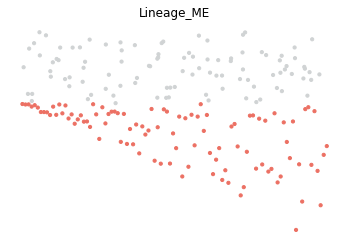

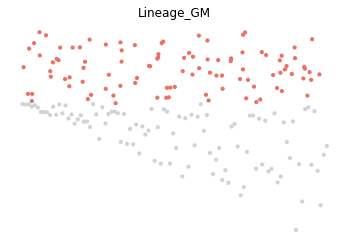

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


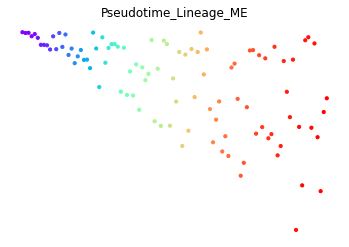

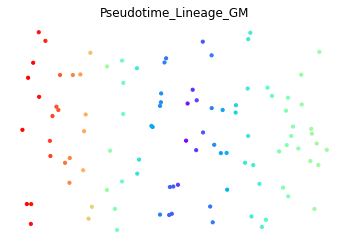

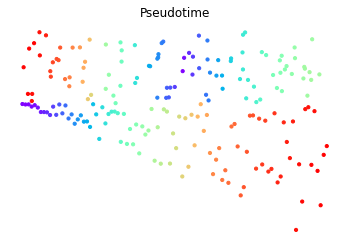

In [75]:
pt = Pseudotime_calculator(adata=adata,
                           obsm_key="X", # Dimensional reduction data name
                           cluster_column_name="annot" # Clustering data name
                           )

# These cluster can be classified into either MEP lineage or GMP lineage

clusters_in_ME_lineage = ['0']
clusters_in_GM_lineage = ['1']

# Make dictionary
lineage_dictionary = {"Lineage_ME": clusters_in_ME_lineage,
           "Lineage_GM": clusters_in_GM_lineage}

# Inpur lineage information into pseudotime object
pt.set_lineage(lineage_dictionary=lineage_dictionary)

# Visualize lineage information
pt.plot_lineages()

#  Estimated root cell name for each lineage
root_cells = {"Lineage_ME": '1', "Lineage_GM": '150'}
pt.set_root_cells(root_cells=root_cells)


sc.pp.neighbors(pt.adata, n_neighbors=30, use_rep='X')
sc.tl.diffmap(pt.adata)
# Calculate pseudotime
pt.get_pseudotime_per_each_lineage()

# Check results
pt.plot_pseudotime(cmap="rainbow")

In [9]:
import numpy as np
import sys
import networkx as nx
from sklearn.neighbors import NearestNeighbors

class HAISU:
    '''Modified from original HAISU https://github.com/Cobanoglu-Lab/Haisu'''
    def __init__(self, graph_labels, ajmatrix):
        self.labels = None
        self.labeldict = {}
        self.graph = None
        self.max_shortestpath = 0
        self.pathcache = None
        self.labelvalues = None
        self.label_probs = []
        self._init_graph(graph_labels, ajmatrix)
        
    def _init_graph(self, graph_labels, ajmatrix):
        # Dictionary from labels:
        cnt = 0
        for label in graph_labels:
            self.labeldict[label] = cnt; cnt+=1
            
        # Make graph & find maximum shortest path:
        self.graph = nx.from_numpy_matrix(ajmatrix)
        for i in range(len(adjmat)-1):
            for j in range(i,len(adjmat)):
                path_len = nx.shortest_path_length(self.graph, i, j)
                if path_len > self.max_shortestpath:
                    self.max_shortestpath = path_len
                    
        self.pathcache = np.ones((len(graph_labels), len(graph_labels))) # max dist (1) for disconnected graphs
        for i in range(len(adjmat)-1):
            for j in range(i,len(adjmat)):
                if(i == j):
                    self.pathcache[i,j] = 0
                elif (nx.shortest_path_length(self.graph, i, j) < 1):
                    self.pathcache[i,j] = 0
                else:
                    self.pathcache[i,j] = (nx.shortest_path_length(self.graph, i, j))/self.max_shortestpath
                    
        
    def get_pairwise_matrix(self, X, ylabels, factor, ylabel_probs=[], n_neighbors=15, 
                            normalize=False, metric='euclidean',n_jobs=1):

        
        if len(ylabel_probs) == len(ylabels):
            self.label_probs = ylabel_probs
        
        if(len(ylabels) != X.shape[0]):
            print('%d labels provided for %d columns/samples.' %(len(ylabels),X.shape[0]))
            print('Please provide the input matrix with axis=1 as the labeled samples, or specify transpose arg.')
            sys.exit("Columns do not match labels.")

        self.labels = ylabels
        
        print('X.shape',X.shape);
        print('len(ylabels)', len(ylabels));

        # Compute euclidean distance based on the axis with labels (1):

        distances = NearestNeighbors(n_neighbors=n_neighbors,
                                     metric=metric, n_jobs=n_jobs).fit(X).kneighbors_graph()

        pathpairwise = self.path_pairwise(factor)
        np.fill_diagonal(pathpairwise, 0)
        distances = np.multiply(distances,pathpairwise)

        # Normalize distances
        if normalize:
            distances=(distances-distances.min())/(distances.max()-distances.min())
        
        return distances
    
    def path_dist(self, label1, label2):
        i = self.labeldict.get(self.labels[label1])
        j = self.labeldict.get(self.labels[label2])
        return self.pathcache[i,j]

    def path_pairwise(self, factor = 1):
        shape = len(self.labels)
        dists = np.zeros((shape, shape))
        if(len(self.label_probs) > 0):
            for i in range(shape-1):     # loops over rows of `x`
                for j in range(i,shape): # loops over rows of `y`
                    ijp = min(self.label_probs[i],self.label_probs[j])
                    dists[i, j] = dists[j, i] = (1-(factor*ijp))+self.path_dist(i,j)*(factor*ijp) 
        else:
            for i in range(shape-1):     # loops over rows of `x`
                for j in range(i,shape): # loops over rows of `y`
                    dists[i, j] = dists[j, i] = (1-factor)+self.path_dist(i,j)*factor
        return dists

# Markers

In [3]:
adata=adata[:,:1000].copy()


In [4]:
adata.uns['workdir']=''
st2.tl.seed_graph(adata)
st2.tl.learn_graph(adata)
st2.tl.infer_pseudotime(adata,source=0,target=1)
st2.tl.detect_transition_markers(adata,use_precomputed=False)

Seeding initial elastic principal graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...
